In [1]:
import gym
import numpy as np
import pandas as pd
import seaborn as sns
from gym import spaces
import matplotlib.pyplot as plt

 # Very broad Introduction
 
The notebook's purpose is to develop and implement a custom environment for the hydrogen refuelling station. This environment will be the basic brick of the RL approach for the minimization of electric costs. 
In order to be able to implement this environment it will be useful to just remind the basic blocks of Reinforcement Learning. To implement RL approaches, there are three main components, the need to be defined:

- An **Environment**: It contains everything outside the agent and everything it interacts with.

- A **state**: The representation of the environment, the agent receives. The set of all potential states. The state space corresponds to all possible states in which our agent can evolve in.

- **Actions**: From the state received, the agente takes an action. The set of all potential action space is the action space.

Both action space and state space, can either be discrete or continuous.

It is necessary to have a precise definition of these three parts for the RL environment.
- How is the state space going to be defined ?
- What is the environment that ought to be chosen ?
- What actions will be defined first ?

But first and foremost:
- What is the main purpose of the agent ? For this, the answer is clear, the agent will have to minimize electricity costs. Another fundamental concept in RL is the **reward** function that needs to be maximized.

In order to implement the some data is imported so that different classes and methods can be tested.


# Importing data

For this study, a toy example of data will be used. This dataframe contains the wind speed indications from a ground station in the north west of France, and it contains a simulated hydrogen demand based on a poisson process.

In [2]:
wind_hydrogen = pd.read_csv('../data/wind_hydrogen_data_2.csv', parse_dates=['date'], 
                            date_parser=pd.to_datetime)
wind_hydrogen_15min = pd.read_csv('../data/wind_hydrogen_data_15min.csv', parse_dates=['date'], 
                            date_parser=pd.to_datetime)

In [3]:
wind_hydrogen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                26304 non-null  datetime64[ns]
 1   wind_speed          26286 non-null  float64       
 2   fcev_demand_hourly  26304 non-null  int64         
 3   h2_amount           26304 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 822.1 KB


In [4]:
wind_hydrogen_15min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105216 entries, 0 to 105215
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         105216 non-null  datetime64[ns]
 1   wind_speed   105120 non-null  float64       
 2   fcev_demand  105216 non-null  int64         
 3   h2_amount    105216 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 3.2 MB


In [5]:
wind_hydrogen = wind_hydrogen.astype({"fcev_demand_hourly": float})
wind_hydrogen_15min = wind_hydrogen_15min.astype({"fcev_demand": float})

In [6]:
wind_hydrogen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                26304 non-null  datetime64[ns]
 1   wind_speed          26286 non-null  float64       
 2   fcev_demand_hourly  26304 non-null  float64       
 3   h2_amount           26304 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 822.1 KB


In [7]:
def grid_tariffs(date):
    
    month = date.month
    hour = date.hour
    
    if month in [1, 2, 12]:
        
        if (hour >= 6 and hour < 8) or \
        (hour >= 10 and hour < 17) or \
        (hour >= 19 and hour < 22):
            
            x = 'HPH'
            
        elif (hour >= 8 and hour < 10) or \
        (hour >= 17 and hour <= 19):
            
            x = 'P'
            
        else:
            x = 'HCH'
            
    elif month in [3, 11]:
        
        if hour >= 6 and hour < 22:
            x = 'HPH'
        else:
            x = 'HCH'
    else:
        if hour >= 6 and hour < 22:
            x = 'HPE'
        else:
            x = 'HCE'
            
    return x

In [8]:
wind_hydrogen['tariffs'] = wind_hydrogen['date'].map(grid_tariffs)

In [9]:
wind_hydrogen_15min['tariffs'] = wind_hydrogen_15min['date'].map(grid_tariffs)

In [10]:
wind_hydrogen_15min.tail()

date  wind_speed  fcev_demand  h2_amount tariffs
105211 2018-12-31 22:45:00    1.900000          3.0       9.39     HCH
105212 2018-12-31 23:00:00    2.000000          1.0       3.13     HCH
105213 2018-12-31 23:15:00    1.700000          1.0       3.13     HCH
105214 2018-12-31 23:30:00    1.866667          1.0       3.13     HCH
105215 2018-12-31 23:45:00    2.250000          1.0       3.13     HCH

In [11]:
wind_hydrogen.tail()

date  wind_speed  fcev_demand_hourly  h2_amount tariffs
26299 2018-12-31 19:00:00        0.95                 4.0      12.52     HPH
26300 2018-12-31 20:00:00        1.71                 2.0       6.26     HPH
26301 2018-12-31 21:00:00        2.16                 4.0      12.52     HPH
26302 2018-12-31 22:00:00        1.97                 1.0       3.13     HCH
26303 2018-12-31 23:00:00        1.95                 2.0       6.26     HCH

In [12]:
wind_hydrogen.set_index('date', inplace=True)

In [13]:
wind_hydrogen_15min.set_index('date', inplace=True)

In [14]:
wind_hydrogen['month'] = wind_hydrogen.index.month
wind_hydrogen['hour'] = wind_hydrogen.index.hour

In [15]:
wind_hydrogen_15min['month'] = wind_hydrogen_15min.index.month
wind_hydrogen_15min['hour'] = wind_hydrogen_15min.index.hour

In [16]:
wind_hydrogen.head()

wind_speed  fcev_demand_hourly  h2_amount tariffs  month  \
date                                                                            
2016-01-01 00:00:00        3.05                 2.0       6.26     HCH      1   
2016-01-01 01:00:00        2.57                 3.0       9.39     HCH      1   
2016-01-01 02:00:00        2.26                 3.0       9.39     HCH      1   
2016-01-01 03:00:00        2.62                 3.0       9.39     HCH      1   
2016-01-01 04:00:00        2.99                 2.0       6.26     HCH      1   

                     hour  
date                       
2016-01-01 00:00:00     0  
2016-01-01 01:00:00     1  
2016-01-01 02:00:00     2  
2016-01-01 03:00:00     3  
2016-01-01 04:00:00     4

In [17]:
wind_hydrogen_15min.head()

wind_speed  fcev_demand  h2_amount tariffs  month  hour
date                                                                        
2016-01-01 00:00:00    4.033333          3.0       9.39     HCH      1     0
2016-01-01 00:15:00    3.100000          0.0       0.00     HCH      1     0
2016-01-01 00:30:00    2.600000          0.0       0.00     HCH      1     0
2016-01-01 00:45:00    2.200000          1.0       3.13     HCH      1     0
2016-01-01 01:00:00    2.666667          1.0       3.13     HCH      1     1

Now that tarifs are fixed based on EDF tarif Vert A5 2022: https://www.fournisseurs-electricite.com/edf/pro/tarifs-reglementes/vert#Le_tarif_vert_A5

Below is a dictionary matching the time period as key and the price as value. For the price, EDF distinguishes them by span of use. It will be considered that a hydrogen refuelling station is in the "Très Longues Utilisation" category. It is then this price range that will be used for now.

In [18]:
price_dict = {"P": 7.154, 
              "HPH": 5.820, 
              "HCH": 4.452,
              "HPE": 4.458,
              "HCE": 2.820}

In [19]:
# Mapping tarifs to their prices
wind_hydrogen['prices'] = wind_hydrogen['tariffs'].map(price_dict)

In [20]:
# Mapping tarifs to their prices
wind_hydrogen_15min['prices'] = wind_hydrogen_15min['tariffs'].map(price_dict)

In [21]:
wind_hydrogen.head()

wind_speed  fcev_demand_hourly  h2_amount tariffs  month  \
date                                                                            
2016-01-01 00:00:00        3.05                 2.0       6.26     HCH      1   
2016-01-01 01:00:00        2.57                 3.0       9.39     HCH      1   
2016-01-01 02:00:00        2.26                 3.0       9.39     HCH      1   
2016-01-01 03:00:00        2.62                 3.0       9.39     HCH      1   
2016-01-01 04:00:00        2.99                 2.0       6.26     HCH      1   

                     hour  prices  
date                               
2016-01-01 00:00:00     0   4.452  
2016-01-01 01:00:00     1   4.452  
2016-01-01 02:00:00     2   4.452  
2016-01-01 03:00:00     3   4.452  
2016-01-01 04:00:00     4   4.452

In [22]:
wind_hydrogen.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2016-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   wind_speed          26286 non-null  float64
 1   fcev_demand_hourly  26304 non-null  float64
 2   h2_amount           26304 non-null  float64
 3   tariffs             26304 non-null  object 
 4   month               26304 non-null  int64  
 5   hour                26304 non-null  int64  
 6   prices              26304 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 1.6+ MB


In [23]:
wind_hydrogen.isna().sum(axis=0)

wind_speed            18
fcev_demand_hourly     0
h2_amount              0
tariffs                0
month                  0
hour                   0
prices                 0
dtype: int64

In [24]:
wind_hydrogen_15min.isna().sum(axis=0)

wind_speed     96
fcev_demand     0
h2_amount       0
tariffs         0
month           0
hour            0
prices          0
dtype: int64

In [25]:
# replacing missing values with forward fill
wind_hydrogen.fillna(method='ffill', inplace=True)

In [26]:
# replacing missing values with forward fill
wind_hydrogen_15min.fillna(method='ffill', inplace=True)

In [27]:
wind_hydrogen.isna().sum(axis=0)

wind_speed            0
fcev_demand_hourly    0
h2_amount             0
tariffs               0
month                 0
hour                  0
prices                0
dtype: int64

In [28]:
wind_hydrogen_15min.isna().sum(axis=0)

wind_speed     0
fcev_demand    0
h2_amount      0
tariffs        0
month          0
hour           0
prices         0
dtype: int64

In [29]:
#wind_hydrogen = wind_hydrogen[["wind_speed", "fcev_demand", "h2_amount", "month", "hour", "prices"]]
# Easier to just drop the column
wind_hydrogen.drop(['tariffs'], axis=1, inplace=True)

In [33]:
wind_hydrogen['prices'] /= 100
wind_hydrogen.head()

wind_speed  fcev_demand_hourly  h2_amount  month  hour  \
date                                                                          
2016-01-01 00:00:00        3.05                 2.0       6.26      1     0   
2016-01-01 01:00:00        2.57                 3.0       9.39      1     1   
2016-01-01 02:00:00        2.26                 3.0       9.39      1     2   
2016-01-01 03:00:00        2.62                 3.0       9.39      1     3   
2016-01-01 04:00:00        2.99                 2.0       6.26      1     4   

                      prices  
date                          
2016-01-01 00:00:00  0.04452  
2016-01-01 01:00:00  0.04452  
2016-01-01 02:00:00  0.04452  
2016-01-01 03:00:00  0.04452  
2016-01-01 04:00:00  0.04452

In [30]:
#wind_hydrogen = wind_hydrogen[["wind_speed", "fcev_demand", "h2_amount", "month", "hour", "prices"]]
# Easier to just drop the column
wind_hydrogen_15min.drop(['tariffs'], axis=1, inplace=True)

In [31]:
wind_hydrogen.head()

wind_speed  fcev_demand_hourly  h2_amount  month  hour  \
date                                                                          
2016-01-01 00:00:00        3.05                 2.0       6.26      1     0   
2016-01-01 01:00:00        2.57                 3.0       9.39      1     1   
2016-01-01 02:00:00        2.26                 3.0       9.39      1     2   
2016-01-01 03:00:00        2.62                 3.0       9.39      1     3   
2016-01-01 04:00:00        2.99                 2.0       6.26      1     4   

                     prices  
date                         
2016-01-01 00:00:00   4.452  
2016-01-01 01:00:00   4.452  
2016-01-01 02:00:00   4.452  
2016-01-01 03:00:00   4.452  
2016-01-01 04:00:00   4.452

In [32]:
# Dividing the price by 100 to get the amount in euros
wind_hydrogen_15min['prices'] /= 100
wind_hydrogen_15min.head()

wind_speed  fcev_demand  h2_amount  month  hour   prices
date                                                                         
2016-01-01 00:00:00    4.033333          3.0       9.39      1     0  0.04452
2016-01-01 00:15:00    3.100000          0.0       0.00      1     0  0.04452
2016-01-01 00:30:00    2.600000          0.0       0.00      1     0  0.04452
2016-01-01 00:45:00    2.200000          1.0       3.13      1     0  0.04452
2016-01-01 01:00:00    2.666667          1.0       3.13      1     1  0.04452

# HRS modelling

It is believed, that the problem of electricity cost minimization, a RL approach can be considered becaus it is believed that the environment would follow a markovian assumption. And that it is possible to take actions that aim at effectively reducing electricity costs.

- It should be kept in mind that the study will be focused on the case of an on-site hydrogen production refuelling station with a mixed energy source (grid + wind turbine)

## Presenting the different components of the refuelling station

There are basically three main components for the HRS:
- Energy sources
    - The renewable energy source producing electricity on-site (for free at this level), as mentionned above only a wind turbine will be considered
    - The main electricity grid containing which supplies electricity if/when needed when renewable energies are not enough. The main grid sells electricity at different tarifs depending on the time of day it is being purchased (based on demand). But it is also possible to sell electricity to the station.

- The refuelling station *complex*, made of all the components:
    - The producing part (electrolysis) which produces hydrogen from water electrolysis, no other technology will be conisdered
    - The storage part: Low pressure hydrogen and after compression, high pressure hydrogen storage tanks
    - The refuelling part: Which distributes hydrogen to vehicles
- Finally the demand side:
    - The FCEVs demand for hydrogen

These make the basic building blocks of the environment and give a precise idea of the potential actions to be taken and state spaces.

But the environment is also made of important information that are available and that play crucial role in the actions taken. Two at least can be taken into consideration:
- The weather data and prediction, because it is essential for the renewable electricity production part
    - In the case of wind electricity wind speed will be necessary, and perhaps the time
- The anticipated demand of hydrogen (a simulation for the moment)

All these components should be modelled in order to make the custom environment.

# Renewable energy components

# Wind turbine representation

The wind turbine, produces electricity in certain certain wind-speed range that are named cut-in speed and cut-out speed. It starts producing electricity when wind speed reaches the level of the cut-in speed, and then it production increases with wind speed up until it reaches a maximum speed limit the cut-out speed after which the turbine stops turning.

A `WindTurbine` class would then require two attributes:
    - Cut-in speed
    - Cut-out speed
And it should contain at least one method `WindTurbine.power_generation(self, speed)` for computing the amount of electricity produced.

In [34]:
class WindTurbine:
    
    def __init__(self, cut_in_speed=3.5, cut_out_speed=20, 
                 rated_speed=10, rated_power=100):
        
        self.cut_in_speed = cut_in_speed
        self.cut_out_speed = cut_out_speed
        self.rated_speed = rated_speed
        self.rated_power = rated_power
        #self.power = power
        
    def power_generation(self, speed):
        
        if speed <= self.cut_in_speed or speed >= self.cut_out_speed:
            
            power = 0. # put the formula here
            
        elif speed >= self.cut_in_speed and speed < self.rated_speed:
            
            denominator = self.rated_speed - self.cut_in_speed
            
            power = speed * (self.rated_power / denominator) 
            power-= self.rated_power * (self.cut_in_speed / denominator)
            # write at the end annoying
            
        elif speed >= self.rated_speed and speed < self.cut_out_speed:
            
            power = self.rated_power
        else:
            raise ValueError('There is a problem')
            
        return power

In [35]:
wt0 = wind_hydrogen.iloc[100]
ws = wt0['wind_speed']

In [36]:
ws

5.42

In [37]:
wt = WindTurbine()
wt.power_generation(ws)

29.53846153846154

# The Hydrogen refuelling station

- The HRS is made of several components, and each of these should be made in a class of its own. Namely:
    - The `Electrolyser` class, implementing the electrolyser
    - The `Compressor` class
    - The `StorageTanks` implementing the hydrogen storage tanks, for the moment no difference will be made concerning low or high pressure storage tanks, even though the difference is important
    - The `PreCooling` class implementing the pre-cooling unit that arrives before distributing hydrogen
    
Except the storage, all other components consume electricity, they must all have a common method `cls.power_consumption()`. The method computes the amount of power consumed by each component.

## The Electrolyser

In [38]:
class Electrolyser:
    
    def __init__(self, lhv=33.3, efficiency=0.6, 
                 min_power=0, max_power=600, hour_prod=10):
        
        self._lhv = lhv # in kWh/kg
        self._efficiency = efficiency # 60%
        self._min_power = min_power # kW
        self._max_power = max_power # kW
        self._hour_prod = hour_prod # hydrogen produced per hour in kg
        
    def power_consumption(self, hy_elec, delta=1):
        """
        Parameters:
        -----------
        hy_elec: (float) Amount of hydrogen produced by the electrolyzer
        delta: (float) Value between zero and one for the electrolyzer efficiency
        
        returns:
        --------
        power_need: (float) amount of power needed for the electrolyzer
        """
        
        numerator = hy_elec * self._lhv
        denominator = self._efficiency * delta
        power_need = (numerator / denominator) * 100
        return power_need

    def get_hour_prod(self):
        """returns the amount of hydrogen produced per hour. 
        It is a private attribute, that is given at instanciation"""
        return self._hour_prod

In [39]:
elec = Electrolyser()
elec.power_consumption(8.)

44400.0

In [40]:
class Compressor:
    
    def __init__(self, heat_cp=14.304, 
                 pressure_in=1, pressure_out=90, 
                 t_in=293, motor_eff=0.9, 
                 comp_eff=0.7, r=1.4):
        
        # Specific heat of hydrogen at constant pressure [kJ/kg/K]
        self.heat_cp = heat_cp
        self.pressure_in = pressure_in # MPa
        self.pressure_out = pressure_out # MPa
        self.t_in = t_in # Hydrogen temperature at the compressor inlet [K]
        self.motor_eff = motor_eff # %
        self.comp_eff = comp_eff # %
        self.r = r # ratio of specific heat of hydrogen
    
    def power_consumption(self, hy_prod, delta=1):
        
        power = self.heat_cp * ((self.t_in * 1e4)/self.motor_eff * self.comp_eff * delta)
        power = power * ((self.pressure_out/self.pressure_in)**((self.r-1)/self.r) - 1)
        power = power * (hy_prod / 3600)
        
        return power

In [41]:
comp = Compressor()
comp.power_consumption(8)

189574.90044858874

## The storage tank

In [42]:
class StorageTank:
    
    def __init__(self, 
                 min_capacity=3, 
                 max_capacity=30, 
                 loss_coef=0.01):
        
        self.min_capacity = min_capacity # kg
        self.max_capacity = max_capacity # kg
        self.loss_coef = loss_coef # %
        self.capacity = max_capacity / 2 # should perhaps be made into a private attribute ._capacity
        
    def available_amount(self, step_idx, h_prod_elec, h_demand):

        storage_amount = (1 - self.loss_coef)*self.capacity

        storage_amount = storage_amount + h_prod_elec - h_demand

        self.capacity = storage_amount

    def get_capacity(self):

        return self.capacity

    def set_capacity(self, capacity):
        
        self.capacity = capacity

    def store_hydrogen(self, hy_amount):

        self.capacity += hy_amount

## The Pre cooling unit

In [43]:
class PreCooling:
    
    def __init__(self, chill_energy=0.33):
        
        self.chill_energy = chill_energy
    
    def power_consumption(self, hy_demand):
        
        return self.chill_energy * hy_demand

In [44]:
precool = PreCooling()
precool.power_consumption(8.)

2.64

## The hydrogen station

The hydrogen station just takes all the previously developped components and puts them together.

In [45]:
class HydrogenStation:
    
    def __init__(self, wind_turbine):
        """Class for the hydrogen station, using all different components of the station, 
        the electrolyser, the compressor, the storage tank, the pre cooling unit in addition
        to the renewable energy components"""
        
        self.electrolyser = Electrolyser()
        self.compressor = Compressor()
        self.storage_tank = StorageTank()
        self.pre_cooling = PreCooling()
        self.wind_turbine = wind_turbine
        
        
    def power_consumption(self, hy_demand, wind_speed, 
                          delta_elec=1., delta_comp=1., clean=True):

#         hy_prod = self.electrolyser.get_hour_prod() # get the hour production of the electrolyser

        pc_elec = self.electrolyser.power_consumption(hy_demand, delta_elec)
        pc_comp = self.compressor.power_consumption(hy_demand, delta_comp) # hourly production
        pc_precool = self.pre_cooling.power_consumption(hy_demand)

        # Compute the amount of power necessary for the station's components
        pc_total = pc_elec + pc_comp + pc_precool
        
        if clean:
            # Get the clean power production
            clean_power = self._clean_energy_production(wind_speed)

            # Compute total needed power
            required_power = pc_total - clean_power
            
            if required_power <= 0.:
                
                return 0.
            
            else:
                
                return required_power
            
        else:
            
            return pc_total


    def buy_from_grid(self, hy_demand, price, wind_speed, 
                      delta_elec=1, delta_comp=1, clean=True):

        required_power = self.power_consumption(hy_demand, wind_speed, 
                                                delta_elec, delta_comp, clean)
        elec_price = required_power * price

        return elec_price

    def _clean_energy_production(self, wind_speed):

        clean_power = self.wind_turbine.power_generation(wind_speed)
        return clean_power


    def refuel(self, hy_demand, wind_speed, price):

        capacity = self.storage_tank.get_capacity()

        if h_demand <= capacity:

            capacity -= hy_demand
            self.storage_tank.set_capacity(capacity) # Updates the storage capacity

        else: # Hydrogen needs to be produced
            required_power = self.power_consumption(hy_demand, wind_speed)
            elec_price = self.buy_from_grid(required_power, price)

            # Because it is fixed to 10 kg per hour, hourly production of electrolyser
            self.storage_tank.set_capacity(10)
            capacity = self.storage_tank.get_capacity()
            new_capacity = capacity - hy_demand
            self.storage_tank.set_capacity(new_capacity)

After creating the necessary components for refuelling stations, a custom environment is developped in order to represent the set of actions, the observation spaces and state spaces for the agent to make decisions.

# Implementing a simple RL agent to start with

Before starting to fully implement the model, it  might be wise to start with an easy toy example that would perform simple actions and tasks.

Let us start with a discrete set of actions where the agent would simply start with whether it buys electricity from the grid or not.
- Buy electricity to produce hydrogen and store it (for the moment)
- Produce hydrogen from Renewable source and store it
- Do nothing

For this case, the basic reward function would be the total price of electricity that should be multiplied by -1 since the objective is to minimize it except in the case where electricity is produced out of renewable energies. **So the smaller the electricity cost, the larger the reward will be.**

In the first easy case, some prerequisites will be arbitrarily admitted:
- If there is the storage capacity of refueller is not enough, hydrogen will be compressed immediately (compression time is zero) which will make hydrogen capacity constantly available, but the amount of power necessary will be taken into consideration
- PROBLEM: If storage tanks are not taken into consideration, then it will be hard to enjoy renewable source...
- Naturally from the point above, storage tanks potentiall have an infinite amount of hydrogen (for the moment it will do)

In [46]:
class HydrogenStationEnv(gym.Env):
    
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df):
        super(HydrogenStationEnv, self).__init__()
        
        # Defining all the components of the 
        
#         self.episode_idx = 0
        self.current_step = 0
        self.df = df # takes the dataframe containing the required information
        self.storage_capacity = 30.
        
        wt = WindTurbine() # Energy produced by wind turbine will always be used when possible
        
        self.hrs = HydrogenStation(wt)
                
        # Three basic actions are defined:
        # - Buy electricity from the grid to produce hydrogen and store it
        # - Store hydrogen produced from renewable energy
        # - Do nothing
        self.action_space = spaces.Discrete(3)
        
        # The observation space is a basic numpy array containing the following information:
        # - The wind speed at hour h (m.s-1)
        # - The fcev demand at hour h (number of vehicles to fuel)
        # - The h2 amount needed (in kg of hydrogen)
        # - The month
        # - The hour
        # - The price of electricity at hour h (based on the hour and month for the season)
        # - Th storage amount of hydrogen available (for the moment, the only information that the agent modifies)
        # For the moment, only one row for with the data at hour h is used
        self.observation_space = spaces.Box(
          low=-np.inf, high=np.inf, shape=(7,), dtype=np.float64)
        
    def reset(self):
        
        # Reset the env

        self.storage_capacity = 30.

        # Set the current step to a random point within the data frame's length
        # self.current_step = random.randint(0, len(self.df)-26)
        self.current_step = 0

        frame = self.df.iloc[self.current_step].values
        obs = np.append(frame, [self.storage_capacity], axis=0)

        return obs


    def step(self, action: any) -> 'Tuple[np.array, float, bool, dict]':
        
        price = self.df.iloc[self.current_step]['prices']
        hy_demand = self.df.iloc[self.current_step]['h2_amount']
        wind_speed = self.df.iloc[self.current_step]['wind_speed']
                
        # initializing a reward
        reward = 0.
        
        # Hydrogen demand must be always be satisfied
        remnant = self.storage_capacity - hy_demand
        
        if remnant <=0:
            
            while remnant <= 0:
                
                elec_price = self.hrs.buy_from_grid(1., price, wind_speed)
                reward += -1 * elec_price
                # adding the hour production (divided by four for 15 min)
                self.storage_capacity += 1. 
                remnant = self.storage_capacity - hy_demand

            self.storage_capacity -= hy_demand
        else:
            self.storage_capacity -= hy_demand


        if action == 0:
            
            # Buy power and store hydrogen
            # For this we need the hour for grid prices
            
            # Then we will need to buy power for hydrogen production
            elec_price = self.hrs.buy_from_grid(10, price, wind_speed, clean=False)
            reward += -1 * elec_price
            
            
            # Once electricy is bought, hydrogen has to be stored -> need to increase storage capacity
            # adding the hour production (divided by four for 15 min)
            self.storage_capacity += self.hrs.electrolyser.get_hour_prod() # adding the hour production
                        

        elif action==1:
            
            #elec_price = self.hrs.buy_from_grid(5., price, wind_speed)
            renewable_power = wt.power_generation(wind_speed)
            pc_hy_10 = self.hrs.power_consumption(10, wind_speed, clean=False)
            ratio = renewable_power / pc_hy_10
            hy_amount = 10 * ratio
            reward += price * renewable_power
                
            # Storing a renewable energy hydrogen with 0 cost, for the moment fixed at 5 kg
            self.storage_capacity += hy_amount
                        
        elif action ==2:
            # do nothing, no reward, no storage
            reward += 0.
            
        else:
            raise ValueError(
                "Received invalid action={} which is not in the action space".format(action))

        frame = self.df.iloc[self.current_step, :].values
        observation = np.append(frame, [self.storage_capacity])

        self.current_step += 1
        done = (self.current_step == len(self.df)-1) # Is done when all the dataframe has been iterated
        info = {} # to fill later

        return observation, reward, done, info

    def render(self, mode='human'):
        
        hy_demand = self.df.iloc[self.current_step]['h2_amount']
        print(f"action taken: {action}")
        print(f"hydrogen demand is: {hy_demand}")
        print(f"current storage capacity is : {self.storage_capacity}")
        print(f"current step: {self.current_step}")
        print("----------current values-------------")
        print(self.df.iloc[self.current_step].values)

    def close(self):
        pass

# Testing the environment

In [47]:
wind_hydrogen.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2016-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   wind_speed          26304 non-null  float64
 1   fcev_demand_hourly  26304 non-null  float64
 2   h2_amount           26304 non-null  float64
 3   month               26304 non-null  int64  
 4   hour                26304 non-null  int64  
 5   prices              26304 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 1.4 MB


In [48]:
from stable_baselines3.common.env_checker import check_env

test = HydrogenStationEnv(wind_hydrogen)
test.step(1)
check_env(test)

In [49]:
# test.reset()
# BUY_AND_STORE = 0
# n_steps = 20
# for step in range(n_steps):
#     action = test.action_space.sample()
#     print("Step {} and action taken {}".format(step + 1, action))
#     obs, reward, done, info = test.step(action)
#     print('obs = ', obs, 'reward = ', reward/100, 'done = ', done)
#     test.render()
#     if done:
#         print("Goal reached!", "reward=", reward)
#         break

# Using a Deep Learning model as a reward optimizer

## Creating a callback to monitor the training

Before training the model here are some functions used to monitor the training with a callback function.

In [50]:
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback


class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq:
    :param log_dir: Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: Verbosity level.
    """
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            
            if len(x) > 0:
                
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}")
                    self.model.save(self.save_path)

        return True

In [51]:
import os
# Create log dir
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

In [81]:
from stable_baselines3.ppo import PPO
from stable_baselines3.a2c import A2C
from stable_baselines3.dqn import DQN
from stable_baselines3.common.env_util import make_vec_env

env = HydrogenStationEnv(wind_hydrogen)
env = Monitor(env, log_dir)

model = A2C("MlpPolicy", env, learning_rate=0.00002, verbose=0) # previous seed: 25876
# model = PPO("MlpPolicy",env, learning_rate=0.0005, batch_size=128, seed=25876, verbose=0)
# model = DQN('MlpPolicy', env, learning_rate=0.00003, batch_size=128, verbose=1)
print("----------------now learning---------------")
callback = SaveOnBestTrainingRewardCallback(check_freq=10000, log_dir=log_dir)
model.learn(total_timesteps=1_000_000, n_eval_episodes=100, callback=callback)
# model.learn(total_timesteps=250_000, n_eval_episodes=50)
# model.learn(total_timesteps=250_000, n_eval_episodes=20, log_interval=4) # for dqn
print("----------------done learning---------------")
# model.save("acc_windhy_3")
# model.save("ppo_windhy")
# model.save("dqn_windhy")

# del model # remove to demonstrate saving and loading

# model = A2C.load("acc_windhy_2_1.zip")
# model = PPO.load("ppo_windhy")
# model = DQN.load("dqn_windhy")

----------------now learning---------------
Num timesteps: 30000
Best mean reward: -inf - Last mean reward per episode: -328999682.28
Saving new best model to tmp/best_model
Num timesteps: 40000
Best mean reward: -328999682.28 - Last mean reward per episode: -328999682.28
Num timesteps: 50000
Best mean reward: -328999682.28 - Last mean reward per episode: -328999682.28
Num timesteps: 60000
Best mean reward: -328999682.28 - Last mean reward per episode: -328981808.93
Saving new best model to tmp/best_model
Num timesteps: 70000
Best mean reward: -328981808.93 - Last mean reward per episode: -328981808.93
Num timesteps: 80000
Best mean reward: -328981808.93 - Last mean reward per episode: -329026476.99
Num timesteps: 90000
Best mean reward: -328981808.93 - Last mean reward per episode: -329026476.99
Num timesteps: 100000
Best mean reward: -328981808.93 - Last mean reward per episode: -329026476.99
Num timesteps: 110000
Best mean reward: -328981808.93 - Last mean reward per episode: -32902

Num timesteps: 840000
Best mean reward: -328981808.93 - Last mean reward per episode: -329010055.86
Num timesteps: 850000
Best mean reward: -328981808.93 - Last mean reward per episode: -329007545.39
Num timesteps: 860000
Best mean reward: -328981808.93 - Last mean reward per episode: -329007545.39
Num timesteps: 870000
Best mean reward: -328981808.93 - Last mean reward per episode: -329004148.14
Num timesteps: 880000
Best mean reward: -328981808.93 - Last mean reward per episode: -329004148.14
Num timesteps: 890000
Best mean reward: -328981808.93 - Last mean reward per episode: -329004148.14
Num timesteps: 900000
Best mean reward: -328981808.93 - Last mean reward per episode: -329005412.64
Num timesteps: 910000
Best mean reward: -328981808.93 - Last mean reward per episode: -329005412.64
Num timesteps: 920000
Best mean reward: -328981808.93 - Last mean reward per episode: -329005412.64
Num timesteps: 930000
Best mean reward: -328981808.93 - Last mean reward per episode: -329003833.91


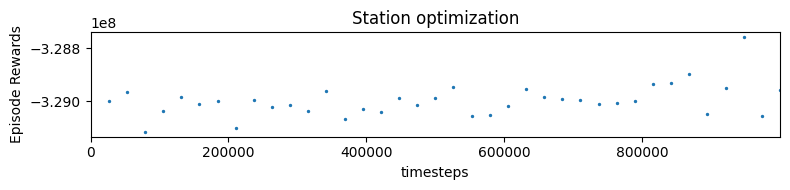

In [82]:
# 1000000 step, learning rate 0.00002, n_eval_episodes=100
plot_results([log_dir], 1_000_000, results_plotter.X_TIMESTEPS, "Station optimization")
plt.show()
# plt.savefig("./plots/reward_evolution.png")

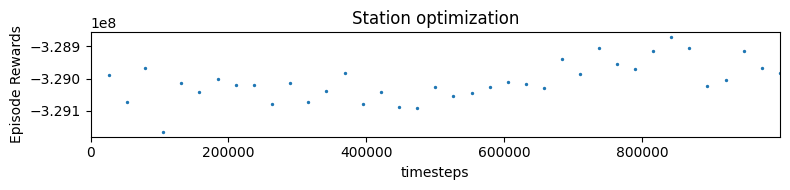

In [62]:
# 1000000 step, learning rate 0.00002, n_eval_episodes=50
plot_results([log_dir], 1_000_000, results_plotter.X_TIMESTEPS, "Station optimization")
plt.show()
# plt.savefig("./plots/reward_evolution.png")

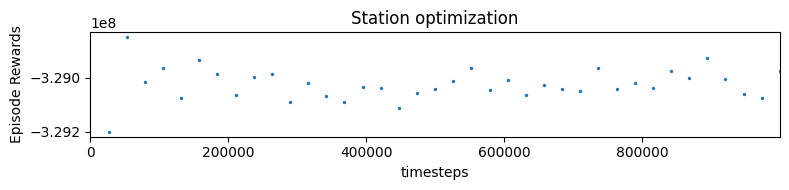

In [72]:
# 1000000 step, learning rate 0.00001
plot_results([log_dir], 1_000_000, results_plotter.X_TIMESTEPS, "Station optimization")
plt.show()
# plt.savefig("./plots/reward_evolution.png")

In [93]:
model.save("acc_windhy_6")

In [131]:
# model = A2C.load("acc_windhy_4.zip")

In [83]:
reward_list = []
action_list = []
obs = env.reset()
done = False
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    action_list.append(action)
    reward_list.append(rewards)
    env.render()

action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 23.740000000000002
current step: 1
----------current values-------------
[2.57    3.      9.39    1.      1.      0.04452]
action taken: 0
hydrogen demand is: 9.39
current storage capacity is : 24.35
current step: 2
----------current values-------------
[2.26    3.      9.39    1.      2.      0.04452]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 14.96
current step: 3
----------current values-------------
[2.62    3.      9.39    1.      3.      0.04452]
action taken: 0
hydrogen demand is: 6.26
current storage capacity is : 15.57
current step: 4
----------current values-------------
[2.99    2.      6.26    1.      4.      0.04452]
action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 9.31
current step: 5
----------current values-------------
[ 2.5      5.      15.65     1.       5.       0.04452]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.660

action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.9159762332503458
current step: 232
----------current values-------------
[ 3.89    1.      3.13    1.     16.      0.0582]
action taken: 1
hydrogen demand is: 0.0
current storage capacity is : 0.7861813811457721
current step: 233
----------current values-------------
[ 3.52     0.       0.       1.      17.       0.07154]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.7861919015506658
current step: 234
----------current values-------------
[ 4.14     4.      12.52     1.      18.       0.07154]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.2665285545072628
current step: 235
----------current values-------------
[ 3.25    3.      9.39    1.     19.      0.0582]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.8765285545072619
current step: 236
----------current values-------------
[ 3.64    4.     12.52    1.     20.      0.0582]
action 

action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.21746167420547025
current step: 491
----------current values-------------
[ 3.31    2.      6.26    1.     11.      0.0582]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.9574616742054705
current step: 492
----------current values-------------
[ 3.75    3.      9.39    1.     12.      0.0582]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.5675931792666404
current step: 493
----------current values-------------
[ 3.73    1.      3.13    1.     13.      0.0582]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.43771416392291723
current step: 494
----------current values-------------
[ 3.11    4.     12.52    1.     14.      0.0582]
action taken: 2
hydrogen demand is: 0.0
current storage capacity is : 0.917714163922918
current step: 495
----------current values-------------
[ 3.61    0.      0.      1.     15.      0.0582]
action taken: 2
hyd

action taken: 1
hydrogen demand is: 0.0
current storage capacity is : 0.558755972129541
current step: 751
----------current values-------------
[6.73   0.     0.     2.     7.     0.0582]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.558755972129541
current step: 752
----------current values-------------
[6.26    2.      6.26    2.      8.      0.07154]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.2987559721295412
current step: 753
----------current values-------------
[7.85    1.      3.13    2.      9.      0.07154]
action taken: 1
hydrogen demand is: 28.17
current storage capacity is : 0.1710441601939092
current step: 754
----------current values-------------
[ 8.21    9.     28.17    2.     10.      0.0582]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.003521715546359914
current step: 755
----------current values-------------
[ 8.65    2.      6.26    2.     11.      0.0582]
action taken: 2
hydrogen d

action taken: 1
hydrogen demand is: 18.78
current storage capacity is : 0.04644490048599437
current step: 1011
----------current values-------------
[ 3.67     6.      18.78     2.       3.       0.04452]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.2665343239275892
current step: 1012
----------current values-------------
[3.38    3.      9.39    2.      4.      0.04452]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.8765343239275882
current step: 1013
----------current values-------------
[4.26    3.      9.39    2.      5.      0.04452]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.48653432392758766
current step: 1014
----------current values-------------
[ 4.01    4.     12.52    2.      6.      0.0582]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.966802594252376
current step: 1015
----------current values-------------
[4.67   2.     6.26   2.     7.     0.0582]
action taken

action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 1.1964862047819675
current step: 1272
----------current values-------------
[4.69    3.      9.39    2.      0.      0.04452]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.8071121688731389
current step: 1273
----------current values-------------
[4.76    1.      3.13    2.      1.      0.04452]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.6777749543814384
current step: 1274
----------current values-------------
[5.7     3.      9.39    2.      2.      0.04452]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.28777495438143674
current step: 1275
----------current values-------------
[3.82    2.      6.26    2.      3.      0.04452]
action taken: 2
hydrogen demand is: 18.78
current storage capacity is : 0.027774954381436956
current step: 1276
----------current values-------------
[ 2.29     6.      18.78     2.       4.       0.04452]
actio

action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.17981023055332201
current step: 1530
----------current values-------------
[ 1.02    3.      9.39    3.     18.      0.0582]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.7898102305533214
current step: 1531
----------current values-------------
[ 1.18    3.      9.39    3.     19.      0.0582]
action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 0.3998102305533209
current step: 1532
----------current values-------------
[ 2.18    5.     15.65    3.     20.      0.0582]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.7498102305533205
current step: 1533
----------current values-------------
[ 1.79    3.      9.39    3.     21.      0.0582]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.35981023055331995
current step: 1534
----------current values-------------
[ 2.65     2.       6.26     3.      22.       0.04452]
action

action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.27214185380519273
current step: 1791
----------current values-------------
[ 8.32    2.      6.26    3.     15.      0.0582]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.014677271384561949
current step: 1792
----------current values-------------
[ 7.96    3.      9.39    3.     16.      0.0582]
action taken: 2
hydrogen demand is: 18.78
current storage capacity is : 0.6246772713845612
current step: 1793
----------current values-------------
[ 8.49    6.     18.78    3.     17.      0.0582]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.8446772713845618
current step: 1794
----------current values-------------
[ 9.45    2.      6.26    3.     18.      0.0582]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.584677271384562
current step: 1795
----------current values-------------
[ 9.29    3.      9.39    3.     19.      0.0582]
action taken

action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.35616713641469033
current step: 2041
----------current values-------------
[1.88    2.      6.26    3.      1.      0.04452]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.09616713641469055
current step: 2042
----------current values-------------
[2.71    3.      9.39    3.      2.      0.04452]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.70616713641469
current step: 2043
----------current values-------------
[2.23    1.      3.13    3.      3.      0.04452]
action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 0.5761671364146901
current step: 2044
----------current values-------------
[ 3.73     5.      15.65     3.       4.       0.04452]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.9261671364146888
current step: 2045
----------current values-------------
[3.98    1.      3.13    3.      5.      0.04452]
action t

action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.85484185352027
current step: 2285
----------current values-------------
[3.3    3.     9.39   4.     5.     0.0282]
action taken: 0
hydrogen demand is: 3.13
current storage capacity is : 10.46484185352027
current step: 2286
----------current values-------------
[3.58    1.      3.13    4.      6.      0.04458]
action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 7.3348418535202695
current step: 2287
----------current values-------------
[ 3.57     5.      15.65     4.       7.       0.04458]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.6848786749373978
current step: 2288
----------current values-------------
[4.62    3.      9.39    4.      8.      0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.2948786749373973
current step: 2289
----------current values-------------
[4.36    2.      6.26    4.      9.      0.04458]
action taken: 1
h

action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.4986372336467117
current step: 2542
----------current values-------------
[ 4.55    4.     12.52    4.     22.      0.0282]
action taken: 1
hydrogen demand is: 21.91
current storage capacity is : 0.9791895549036281
current step: 2543
----------current values-------------
[ 4.96    7.     21.91    4.     23.      0.0282]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.06995754446086289
current step: 2544
----------current values-------------
[4.24   3.     9.39   4.     0.     0.0282]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.680346799441927
current step: 2545
----------current values-------------
[4.49   3.     9.39   4.     1.     0.0282]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.29086755948416276
current step: 2546
----------current values-------------
[4.17   2.     6.26   4.     2.     0.0282]
action taken: 1
hydrogen deman

action taken: 2
hydrogen demand is: 18.78
current storage capacity is : 0.09916915736458343
current step: 2797
----------current values-------------
[ 8.48     6.      18.78     4.      13.       0.04458]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.3217887381831018
current step: 2798
----------current values-------------
[ 7.99     4.      12.52     4.      14.       0.04458]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.8041505690817258
current step: 2799
----------current values-------------
[ 7.83     1.       3.13     4.      15.       0.04458]
action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 0.6764282367412
current step: 2800
----------current values-------------
[ 8.15     5.      15.65     4.      16.       0.04458]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.028874230878972666
current step: 2801
----------current values-------------
[ 8.57     4.      12.52     4.      

action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.7725019948242977
current step: 3058
----------current values-------------
[ 4.38     4.      12.52     5.      10.       0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.25250199482429814
current step: 3059
----------current values-------------
[ 4.52     2.       6.26     5.      11.       0.04458]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.9930385354738742
current step: 3060
----------current values-------------
[ 4.55     4.      12.52     5.      12.       0.04458]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.47303853547387575
current step: 3061
----------current values-------------
[ 3.88     1.       3.13     5.      13.       0.04458]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.3432384231668551
current step: 3062
----------current values-------------
[ 3.48     2.       6.26     5.      

action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.23638786383812516
current step: 3313
----------current values-------------
[2.36   1.     3.13   5.     1.     0.0282]
action taken: 2
hydrogen demand is: 18.78
current storage capacity is : 0.10638786383812526
current step: 3314
----------current values-------------
[ 2.99    6.     18.78    5.      2.      0.0282]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.326387863838125
current step: 3315
----------current values-------------
[2.51   2.     6.26   5.     3.     0.0282]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.06638786383812523
current step: 3316
----------current values-------------
[3.79   3.     9.39   5.     4.     0.0282]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.6763878638381247
current step: 3317
----------current values-------------
[ 4.26    4.     12.52    5.      5.      0.0282]
action taken: 2
hydrogen dema

action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.7411355699258095
current step: 3569
----------current values-------------
[ 2.9      2.       6.26     5.      17.       0.04458]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.48113556992580975
current step: 3570
----------current values-------------
[ 1.6      4.      12.52     5.      18.       0.04458]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.9611355699258102
current step: 3571
----------current values-------------
[ 3.54     3.       9.39     5.      19.       0.04458]
action taken: 1
hydrogen demand is: 21.91
current storage capacity is : 0.5711566107355969
current step: 3572
----------current values-------------
[ 6.28     7.      21.91     5.      20.       0.04458]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.6611566107355991
current step: 3573
----------current values-------------
[ 7.61     4.      12.52     5.      

action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.8950933060309438
current step: 3819
----------current values-------------
[1.72   1.     3.13   6.     3.     0.0282]
action taken: 0
hydrogen demand is: 12.52
current storage capacity is : 10.765093306030945
current step: 3820
----------current values-------------
[ 2.67    4.     12.52    6.      4.      0.0282]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.24509330603094526
current step: 3821
----------current values-------------
[2.85   2.     6.26   6.     5.     0.0282]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.9850933060309455
current step: 3822
----------current values-------------
[ 3.4      4.      12.52     6.       6.       0.04458]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.4650933060309459
current step: 3823
----------current values-------------
[2.11    1.      3.13    6.      7.      0.04458]
action taken: 1
hy

action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.8266808217240859
current step: 4070
----------current values-------------
[ 4.93     1.       3.13     6.      14.       0.04458]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.6966808217240859
current step: 4071
----------current values-------------
[ 5.32     3.       9.39     6.      15.       0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.3066808217240862
current step: 4072
----------current values-------------
[ 5.42     2.       6.26     6.      16.       0.04458]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.04769078059387635
current step: 4073
----------current values-------------
[ 5.18     2.       6.26     6.      17.       0.04458]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.7885744946049433
current step: 4074
----------current values-------------
[ 5.17     4.      12.52     6.      18

action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.13960442883871238
current step: 4328
----------current values-------------
[4.87    2.      6.26    6.      8.      0.04458]
action taken: 1
hydrogen demand is: 18.78
current storage capacity is : 0.8803250765739273
current step: 4329
----------current values-------------
[ 5.13     6.      18.78     6.       9.       0.04458]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.10118248957275597
current step: 4330
----------current values-------------
[ 6.87     1.       3.13     6.      10.       0.04458]
action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 0.9711824895727563
current step: 4331
----------current values-------------
[ 6.02     5.      15.65     6.      11.       0.04458]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.32250806058935527
current step: 4332
----------current values-------------
[ 5.1      4.      12.52     6.      12. 

action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.7784506687598745
current step: 4583
----------current values-------------
[ 1.11    2.      6.26    7.     23.      0.0282]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.5184506687598747
current step: 4584
----------current values-------------
[1.89   2.     6.26   7.     0.     0.0282]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.2584506687598749
current step: 4585
----------current values-------------
[1.05   3.     9.39   7.     1.     0.0282]
action taken: 2
hydrogen demand is: 0.0
current storage capacity is : 0.8684506687598734
current step: 4586
----------current values-------------
[1.89   0.     0.     7.     2.     0.0282]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.8684506687598734
current step: 4587
----------current values-------------
[ 2.28    4.     12.52    7.      3.      0.0282]
action taken: 1
hydrogen demand i

action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 1.3626040978013094
current step: 4845
----------current values-------------
[ 3.84     1.       3.13     7.      21.       0.04458]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.2327829446845015
current step: 4846
----------current values-------------
[ 4.3     3.      9.39    7.     22.      0.0282]
action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 0.8432037608802468
current step: 4847
----------current values-------------
[ 4.65    5.     15.65    7.     23.      0.0282]
action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 0.19320376088024638
current step: 4848
----------current values-------------
[ 3.77    5.     15.65    7.      0.      0.0282]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.5432037608802442
current step: 4849
----------current values-------------
[2.96   3.     9.39   7.     1.     0.0282]
action taken

action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.5885207601081993
current step: 5107
----------current values-------------
[ 6.       2.       6.26     7.      19.       0.04458]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.3298358107199053
current step: 5108
----------current values-------------
[ 5.97     2.       6.26     7.      20.       0.04458]
action taken: 1
hydrogen demand is: 0.0
current storage capacity is : 0.07113508072427095
current step: 5109
----------current values-------------
[ 3.37     0.       0.       7.      21.       0.04458]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.07113508072427095
current step: 5110
----------current values-------------
[ 2.93    1.      3.13    7.     22.      0.0282]
action taken: 2
hydrogen demand is: 0.0
current storage capacity is : 0.9411350807242709
current step: 5111
----------current values-------------
[ 3.32    0.      0.      7.     23.      0.028

action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.08742344166193128
current step: 5369
----------current values-------------
[ 6.53     2.       6.26     8.      17.       0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.8274234416619315
current step: 5370
----------current values-------------
[ 5.41     2.       6.26     8.      18.       0.04458]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.5684281403292748
current step: 5371
----------current values-------------
[ 4.53     2.       6.26     8.      19.       0.04458]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.30896994118129734
current step: 5372
----------current values-------------
[ 4.35     3.       9.39     8.      20.       0.04458]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.919417058389277
current step: 5373
----------current values-------------
[ 5.08     1.       3.13     8.      21.

action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 0.8975678861417189
current step: 5625
----------current values-------------
[ 3.64     5.      15.65     8.       9.       0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.24756788614171832
current step: 5626
----------current values-------------
[ 4.11     2.       6.26     8.      10.       0.04458]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.9878887584909747
current step: 5627
----------current values-------------
[ 3.19     2.       6.26     8.      11.       0.04458]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.727888758490975
current step: 5628
----------current values-------------
[ 3.05     1.       3.13     8.      12.       0.04458]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.5978887584909751
current step: 5629
----------current values-------------
[ 2.8      4.      12.52     8.      13

action taken: 1
hydrogen demand is: 21.91
current storage capacity is : 0.39844001430209985
current step: 5872
----------current values-------------
[ 3.34     7.      21.91     9.      16.       0.04458]
action taken: 0
hydrogen demand is: 6.26
current storage capacity is : 10.4884400143021
current step: 5873
----------current values-------------
[ 2.68     2.       6.26     9.      17.       0.04458]
action taken: 2
hydrogen demand is: 18.78
current storage capacity is : 4.2284400143021
current step: 5874
----------current values-------------
[ 2.1      6.      18.78     9.      18.       0.04458]
action taken: 1
hydrogen demand is: 25.04
current storage capacity is : 0.44844001430210056
current step: 5875
----------current values-------------
[ 1.59     8.      25.04     9.      19.       0.04458]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.4084400143021014
current step: 5876
----------current values-------------
[ 0.59     3.       9.39     9.      20. 

action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.228675302817809
current step: 6127
----------current values-------------
[1.31    3.      9.39    9.      7.      0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.8386753028178084
current step: 6128
----------current values-------------
[1.67    2.      6.26    9.      8.      0.04458]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.5786753028178087
current step: 6129
----------current values-------------
[1.5     3.      9.39    9.      9.      0.04458]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.1886753028178081
current step: 6130
----------current values-------------
[ 1.55     3.       9.39     9.      10.       0.04458]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.7986753028178075
current step: 6131
----------current values-------------
[ 2.98     2.       6.26     9.      11.       0.04458]
acti

action taken: 2
hydrogen demand is: 18.78
current storage capacity is : 0.6244646548201995
current step: 6375
----------current values-------------
[ 2.75     6.      18.78     9.      15.       0.04458]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.8444646548202002
current step: 6376
----------current values-------------
[ 2.02     2.       6.26     9.      16.       0.04458]
action taken: 1
hydrogen demand is: 0.0
current storage capacity is : 0.5844646548202004
current step: 6377
----------current values-------------
[ 1.69     0.       0.       9.      17.       0.04458]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.5844646548202004
current step: 6378
----------current values-------------
[ 0.6      3.       9.39     9.      18.       0.04458]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.1944646548201998
current step: 6379
----------current values-------------
[ 0.85     3.       9.39     9.      19. 

action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 0.12892388590072912
current step: 6634
----------current values-------------
[ 3.13     5.      15.65    10.      10.       0.04458]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.47892388590072876
current step: 6635
----------current values-------------
[ 4.31     3.       9.39    10.      11.       0.04458]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.08934996229892084
current step: 6636
----------current values-------------
[ 4.89     4.      12.52    10.      12.       0.04458]
action taken: 0
hydrogen demand is: 12.52
current storage capacity is : 10.569349962298922
current step: 6637
----------current values-------------
[ 5.32     4.      12.52    10.      13.       0.04458]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.05030731914424437
current step: 6638
----------current values-------------
[ 6.2      3.       9.39    10.   

action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.5221883407286496
current step: 6894
----------current values-------------
[ 1.66     1.       3.13    10.       6.       0.04458]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.3921883407286497
current step: 6895
----------current values-------------
[ 1.25     3.       9.39    10.       7.       0.04458]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.002188340728649152
current step: 6896
----------current values-------------
[ 1.03     3.       9.39    10.       8.       0.04458]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.6121883407286486
current step: 6897
----------current values-------------
[ 1.01     1.       3.13    10.       9.       0.04458]
action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 0.4821883407286487
current step: 6898
----------current values-------------
[ 0.87     5.      15.65    10.      1

action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.23972372479479098
current step: 7153
----------current values-------------
[ 1.07    4.     12.52   10.      1.      0.0282]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.7197237247947914
current step: 7154
----------current values-------------
[ 1.17    2.      6.26   10.      2.      0.0282]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.4597237247947916
current step: 7155
----------current values-------------
[ 1.8     4.     12.52   10.      3.      0.0282]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.939723724794792
current step: 7156
----------current values-------------
[ 1.22    4.     12.52   10.      4.      0.0282]
action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 0.4197237247947925
current step: 7157
----------current values-------------
[ 1.6     5.     15.65   10.      5.      0.0282]
action take

action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.24932359426022443
current step: 7410
----------current values-------------
[ 5.56    2.      6.26   11.     18.      0.0582]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.9893235942602248
current step: 7411
----------current values-------------
[ 4.42    3.      9.39   11.     19.      0.0582]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.599807532885331
current step: 7412
----------current values-------------
[ 4.19    4.     12.52   11.     20.      0.0582]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.07980753288533116
current step: 7413
----------current values-------------
[ 5.8     4.     12.52   11.     21.      0.0582]
action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 0.5598075328853316
current step: 7414
----------current values-------------
[ 6.14     5.      15.65    11.      22.       0.04452]
actio

action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.41754031860434004
current step: 7667
----------current values-------------
[ 5.59    2.      6.26   11.     11.      0.0582]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.15754031860434026
current step: 7668
----------current values-------------
[ 5.09    2.      6.26   11.     12.      0.0582]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.8975403186043405
current step: 7669
----------current values-------------
[ 4.16    2.      6.26   11.     13.      0.0582]
action taken: 2
hydrogen demand is: 0.0
current storage capacity is : 0.6375403186043407
current step: 7670
----------current values-------------
[ 4.94    0.      0.     11.     14.      0.0582]
action taken: 2
hydrogen demand is: 18.78
current storage capacity is : 0.6375403186043407
current step: 7671
----------current values-------------
[ 5.6     6.     18.78   11.     15.      0.0582]
action taken:

action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 0.12978458227975015
current step: 7916
----------current values-------------
[ 5.1     5.     15.65   11.     20.      0.0582]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.4797845822797502
current step: 7917
----------current values-------------
[ 4.79    1.      3.13   11.     21.      0.0582]
action taken: 1
hydrogen demand is: 18.78
current storage capacity is : 0.35046314839539044
current step: 7918
----------current values-------------
[ 4.11     6.      18.78    11.      22.       0.04452]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.5707840207446465
current step: 7919
----------current values-------------
[ 3.5      1.       3.13    11.      23.       0.04452]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.44078402074464673
current step: 7920
----------current values-------------
[ 3.06     1.       3.13    11.       0.       0

action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.6149374497860922
current step: 8177
----------current values-------------
[ 3.64     2.       6.26    12.      17.       0.07154]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.35493744978609243
current step: 8178
----------current values-------------
[ 3.1      4.      12.52    12.      18.       0.07154]
action taken: 2
hydrogen demand is: 0.0
current storage capacity is : 0.8349374497860929
current step: 8179
----------current values-------------
[ 2.66    0.      0.     12.     19.      0.0582]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.8349374497860929
current step: 8180
----------current values-------------
[ 3.03    1.      3.13   12.     20.      0.0582]
action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 0.704937449786093
current step: 8181
----------current values-------------
[ 3.65    5.     15.65   12.     21.      0.0582]
ac

action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.5662465298981711
current step: 8438
----------current values-------------
[ 1.08    1.      3.13   12.     14.      0.0582]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.43624652989817125
current step: 8439
----------current values-------------
[ 1.71    3.      9.39   12.     15.      0.0582]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.0462465298981698
current step: 8440
----------current values-------------
[ 1.25    2.      6.26   12.     16.      0.0582]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.78624652989817
current step: 8441
----------current values-------------
[ 0.95     4.      12.52    12.      17.       0.07154]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.26624652989817044
current step: 8442
----------current values-------------
[ 1.25     3.       9.39    12.      18.       0.07154]
ac

action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.47394640083451467
current step: 8699
----------current values-------------
[ 2.93    4.     12.52   12.     11.      0.0582]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.9539464008345142
current step: 8700
----------current values-------------
[ 3.01    3.      9.39   12.     12.      0.0582]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.5639464008345136
current step: 8701
----------current values-------------
[ 3.01    1.      3.13   12.     13.      0.0582]
action taken: 1
hydrogen demand is: 0.0
current storage capacity is : 0.43394640083451375
current step: 8702
----------current values-------------
[ 2.94    0.      0.     12.     14.      0.0582]
action taken: 1
hydrogen demand is: 18.78
current storage capacity is : 0.43394640083451375
current step: 8703
----------current values-------------
[ 2.8     6.     18.78   12.     15.      0.0582]
action take

action taken: 1
hydrogen demand is: 0.0
current storage capacity is : 0.9250920595221181
current step: 8959
----------current values-------------
[1.65   0.     0.     1.     7.     0.0582]
action taken: 2
hydrogen demand is: 0.0
current storage capacity is : 0.9250920595221181
current step: 8960
----------current values-------------
[1.72    0.      0.      1.      8.      0.07154]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.9250920595221181
current step: 8961
----------current values-------------
[1.68    3.      9.39    1.      9.      0.07154]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.5350920595221176
current step: 8962
----------current values-------------
[ 2.35    2.      6.26    1.     10.      0.0582]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.2750920595221178
current step: 8963
----------current values-------------
[ 2.49    1.      3.13    1.     11.      0.0582]
action taken: 1
hydroge

action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 4.716524188155607
current step: 9220
----------current values-------------
[4.61    1.      3.13    1.      4.      0.04452]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 1.5865241881556074
current step: 9221
----------current values-------------
[4.08    2.      6.26    1.      5.      0.04452]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.3268292798975233
current step: 9222
----------current values-------------
[3.79   2.     6.26   1.     6.     0.0582]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.06698182576848194
current step: 9223
----------current values-------------
[3.83   2.     6.26   1.     7.     0.0582]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.8069818257684824
current step: 9224
----------current values-------------
[4.06    1.      3.13    1.      8.      0.07154]
action taken: 2
hydrogen de

action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.4151558252222518
current step: 9484
----------current values-------------
[5.75    2.      6.26    1.      4.      0.04452]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.15633937077278715
current step: 9485
----------current values-------------
[5.55    3.      9.39    1.      5.      0.04452]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.766339370772787
current step: 9486
----------current values-------------
[4.98   2.     6.26   1.     6.     0.0582]
action taken: 1
hydrogen demand is: 0.0
current storage capacity is : 0.507117880734917
current step: 9487
----------current values-------------
[4.17   0.     0.     1.     7.     0.0582]
action taken: 2
hydrogen demand is: 0.0
current storage capacity is : 0.507117880734917
current step: 9488
----------current values-------------
[3.26    0.      0.      1.      8.      0.07154]
action taken: 2
hydrogen demand

action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.9641700364731332
current step: 9745
----------current values-------------
[3.26    3.      9.39    2.      1.      0.04452]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.5741700364731326
current step: 9746
----------current values-------------
[3.13    1.      3.13    2.      2.      0.04452]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.4441700364731327
current step: 9747
----------current values-------------
[4.57    2.      6.26    2.      3.      0.04452]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.18473287813494293
current step: 9748
----------current values-------------
[6.05    1.      3.13    2.      4.      0.04452]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.054732878134942986
current step: 9749
----------current values-------------
[4.49    3.      9.39    2.      5.      0.04452]
action taken

action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 0.5602809711219585
current step: 10007
----------current values-------------
[ 5.86     5.      15.65     2.      23.       0.04452]
action taken: 2
hydrogen demand is: 0.0
current storage capacity is : 0.9102809711219582
current step: 10008
----------current values-------------
[5.79    0.      0.      2.      0.      0.04452]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.9102809711219582
current step: 10009
----------current values-------------
[5.09    1.      3.13    2.      1.      0.04452]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.7811173433110031
current step: 10010
----------current values-------------
[5.74    2.      6.26    2.      2.      0.04452]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.521117343311003
current step: 10011
----------current values-------------
[ 6.35     4.      12.52     2.       3.       0.04452

action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.32656016522270015
current step: 10268
----------current values-------------
[ 2.67    4.     12.52    3.     20.      0.0582]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.8065601652227006
current step: 10269
----------current values-------------
[ 2.66    3.      9.39    3.     21.      0.0582]
action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 0.4165601652227
current step: 10270
----------current values-------------
[ 2.28     5.      15.65     3.      22.       0.04452]
action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 0.7665601652226979
current step: 10271
----------current values-------------
[ 3.96     5.      15.65     3.      23.       0.04452]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.11680213453525137
current step: 10272
----------current values-------------
[4.47    1.      3.13    3.      0.      0.044

action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.18000766169048354
current step: 10518
----------current values-------------
[2.48   2.     6.26   3.     6.     0.0582]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.9200076616904838
current step: 10519
----------current values-------------
[2.41   3.     9.39   3.     7.     0.0582]
action taken: 1
hydrogen demand is: 18.78
current storage capacity is : 0.5300076616904832
current step: 10520
----------current values-------------
[ 2.2     6.     18.78    3.      8.      0.0582]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.750007661690482
current step: 10521
----------current values-------------
[2.76   1.     3.13   3.     9.     0.0582]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.6200076616904822
current step: 10522
----------current values-------------
[ 3.09    1.      3.13    3.     10.      0.0582]
action taken: 2
hydrogen de

action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.8474371314105156
current step: 10767
----------current values-------------
[ 6.18    3.      9.39    3.     15.      0.0582]
action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 0.4588468656662635
current step: 10768
----------current values-------------
[ 6.7     5.     15.65    3.     16.      0.0582]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.8105301304492464
current step: 10769
----------current values-------------
[10.47    3.      9.39    3.     17.      0.0582]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.42394926203968025
current step: 10770
----------current values-------------
[ 9.92    1.      3.13    3.     18.      0.0582]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.2939492620396802
current step: 10771
----------current values-------------
[10.23    4.     12.52    3.     19.      0.0582]
action 

action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.8278393258101815
current step: 11014
----------current values-------------
[ 0.84    3.      9.39    4.     22.      0.0282]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.4378393258101809
current step: 11015
----------current values-------------
[ 2.13    4.     12.52    4.     23.      0.0282]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.9178393258101814
current step: 11016
----------current values-------------
[ 0.1     4.     12.52    4.      0.      0.0282]
action taken: 1
hydrogen demand is: 25.04
current storage capacity is : 0.3978393258101818
current step: 11017
----------current values-------------
[ 0.75    8.     25.04    4.      1.      0.0282]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.35783932581018263
current step: 11018
----------current values-------------
[ 1.58    4.     12.52    4.      2.      0.0282]
actio

action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 0.10965303020855544
current step: 11249
----------current values-------------
[ 1.08     5.      15.65     4.      17.       0.04458]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.4596530302085551
current step: 11250
----------current values-------------
[ 2.03     2.       6.26     4.      18.       0.04458]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.1996530302085553
current step: 11251
----------current values-------------
[ 2.05     2.       6.26     4.      19.       0.04458]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.9396530302085555
current step: 11252
----------current values-------------
[ 0.74     3.       9.39     4.      20.       0.04458]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.5496530302085549
current step: 11253
----------current values-------------
[ 1.38     4.      12.52     4.  

action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.9944643397044359
current step: 11484
----------current values-------------
[ 4.71     1.       3.13     4.      12.       0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.864464339704436
current step: 11485
----------current values-------------
[ 4.29     2.       6.26     4.      13.       0.04458]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.6044643397044362
current step: 11486
----------current values-------------
[ 3.97     1.       3.13     4.      14.       0.04458]
action taken: 2
hydrogen demand is: 0.0
current storage capacity is : 0.47446433970443636
current step: 11487
----------current values-------------
[ 4.07     0.       0.       4.      15.       0.04458]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.47446433970443636
current step: 11488
----------current values-------------
[ 4.09     3.       9.39     4.     

action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.11439873123492461
current step: 11744
----------current values-------------
[5.87    1.      3.13    5.      8.      0.04458]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.9843987312349247
current step: 11745
----------current values-------------
[6.72    1.      3.13    5.      9.      0.04458]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.8560925164228017
current step: 11746
----------current values-------------
[ 6.63     3.       9.39     5.      10.       0.04458]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.46773895978865665
current step: 11747
----------current values-------------
[ 6.74     4.      12.52     5.      11.       0.04458]
action taken: 2
hydrogen demand is: 18.78
current storage capacity is : 0.9477389597886567
current step: 11748
----------current values-------------
[ 7.6      6.      18.78     5.      12.    

action taken: 0
hydrogen demand is: 3.13
current storage capacity is : 10.284626628656689
current step: 12006
----------current values-------------
[4.24    1.      3.13    5.      6.      0.04458]
action taken: 0
hydrogen demand is: 9.39
current storage capacity is : 17.15462662865669
current step: 12007
----------current values-------------
[2.62    3.      9.39    5.      7.      0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 7.764626628656689
current step: 12008
----------current values-------------
[3.43    2.      6.26    5.      8.      0.04458]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 1.5046266286566894
current step: 12009
----------current values-------------
[4.18    3.      9.39    5.      9.      0.04458]
action taken: 0
hydrogen demand is: 6.26
current storage capacity is : 10.114626628656689
current step: 12010
----------current values-------------
[ 4.44     2.       6.26     5.      10.       0.04458]
action

action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.6490076669976759
current step: 12268
----------current values-------------
[2.06   1.     3.13   5.     4.     0.0282]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.519007666997676
current step: 12269
----------current values-------------
[ 1.79    4.     12.52    5.      5.      0.0282]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.9990076669976773
current step: 12270
----------current values-------------
[2.46    2.      6.26    5.      6.      0.04458]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.7390076669976775
current step: 12271
----------current values-------------
[3.53    3.      9.39    5.      7.      0.04458]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.34900766699767694
current step: 12272
----------current values-------------
[ 3.6      4.      12.52     5.       8.       0.04458]
action t

action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.09463537331857808
current step: 12520
----------current values-------------
[ 7.33     4.      12.52     6.      16.       0.04458]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.5746353733185785
current step: 12521
----------current values-------------
[ 6.7      1.       3.13     6.      17.       0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.4446353733185786
current step: 12522
----------current values-------------
[ 4.9      2.       6.26     6.      18.       0.04458]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.185371801661134
current step: 12523
----------current values-------------
[ 5.22     2.       6.26     6.      19.       0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.9253718016611341
current step: 12524
----------current values-------------
[ 6.85     2.       6.26     6.    

action taken: 2
hydrogen demand is: 18.78
current storage capacity is : 0.2134809029425888
current step: 12770
----------current values-------------
[ 4.49    6.     18.78    6.      2.      0.0282]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.4334809029425877
current step: 12771
----------current values-------------
[4.09   2.     6.26   6.     3.     0.0282]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.1734809029425879
current step: 12772
----------current values-------------
[3.92   2.     6.26   6.     4.     0.0282]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.9137018314453547
current step: 12773
----------current values-------------
[4.77   1.     3.13   6.     5.     0.0282]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.7843698771561015
current step: 12774
----------current values-------------
[5.86    2.      6.26    6.      6.      0.04458]
action taken: 1
hydrogen de

action taken: 0
hydrogen demand is: 12.52
current storage capacity is : 14.336787794538665
current step: 13018
----------current values-------------
[ 3.13     4.      12.52     6.      10.       0.04458]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 1.8167877945386657
current step: 13019
----------current values-------------
[ 3.61     4.      12.52     6.      11.       0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.2967877945386661
current step: 13020
----------current values-------------
[ 4.05     2.       6.26     6.      12.       0.04458]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.037077105673241566
current step: 13021
----------current values-------------
[ 4.18     2.       6.26     6.      13.       0.04458]
action taken: 0
hydrogen demand is: 15.65
current storage capacity is : 10.777077105673243
current step: 13022
----------current values-------------
[ 5.02     5.      15.65     6.

action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.4663283811828197
current step: 13266
----------current values-------------
[ 4.44     3.       9.39     7.      18.       0.04458]
action taken: 0
hydrogen demand is: 9.39
current storage capacity is : 10.076328381182819
current step: 13267
----------current values-------------
[ 3.81     3.       9.39     7.      19.       0.04458]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.6863283811828182
current step: 13268
----------current values-------------
[ 1.91     3.       9.39     7.      20.       0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.2963283811828177
current step: 13269
----------current values-------------
[ 1.72     2.       6.26     7.      21.       0.04458]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.03632838118281789
current step: 13270
----------current values-------------
[ 1.71    3.      9.39    7.     22

action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.0013451937227104693
current step: 13515
----------current values-------------
[1.53   2.     6.26   7.     3.     0.0282]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.7413451937227107
current step: 13516
----------current values-------------
[1.69   3.     9.39   7.     4.     0.0282]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.351345193722711
current step: 13517
----------current values-------------
[1.12   3.     9.39   7.     5.     0.0282]
action taken: 1
hydrogen demand is: 18.78
current storage capacity is : 0.9613451937227104
current step: 13518
----------current values-------------
[ 1.82     6.      18.78     7.       6.       0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.1813451937227093
current step: 13519
----------current values-------------
[0.83    2.      6.26    7.      7.      0.04458]
action taken: 2
hyd

action taken: 2
hydrogen demand is: 18.78
current storage capacity is : 0.39888619313988105
current step: 13764
----------current values-------------
[ 5.73     6.      18.78     7.      12.       0.04458]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.618886193139879
current step: 13765
----------current values-------------
[ 6.23     4.      12.52     7.      13.       0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.09888619313987945
current step: 13766
----------current values-------------
[ 6.59     2.       6.26     7.      14.       0.04458]
action taken: 1
hydrogen demand is: 21.91
current storage capacity is : 0.8405115956959479
current step: 13767
----------current values-------------
[ 6.56     7.      21.91     7.      15.       0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.9305115956959469
current step: 13768
----------current values-------------
[ 7.       2.       6.26     7. 

action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.431571315401456
current step: 14025
----------current values-------------
[2.54    1.      3.13    8.      9.      0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.3015713154014561
current step: 14026
----------current values-------------
[ 3.15     2.       6.26     8.      10.       0.04458]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.04157131540145631
current step: 14027
----------current values-------------
[ 3.35     1.       3.13     8.      11.       0.04458]
action taken: 2
hydrogen demand is: 0.0
current storage capacity is : 0.9115713154014564
current step: 14028
----------current values-------------
[ 3.61     0.       0.       8.      12.       0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.9115713154014564
current step: 14029
----------current values-------------
[ 4.11     2.       6.26     8.      13.   

action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.057223546991645335
current step: 14287
----------current values-------------
[4.4     3.      9.39    8.      7.      0.04458]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.6676969652118588
current step: 14288
----------current values-------------
[5.56    1.      3.13    8.      8.      0.04458]
action taken: 2
hydrogen demand is: 21.91
current storage capacity is : 0.5376969652118588
current step: 14289
----------current values-------------
[ 5.75     7.      21.91     8.       9.       0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.6276969652118574
current step: 14290
----------current values-------------
[ 6.25     2.       6.26     8.      10.       0.04458]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.3676969652118576
current step: 14291
----------current values-------------
[ 5.17     1.       3.13     8.      11.     

action taken: 0
hydrogen demand is: 6.26
current storage capacity is : 10.04179885767459
current step: 14549
----------current values-------------
[1.2    2.     6.26   8.     5.     0.0282]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 3.7817988576745893
current step: 14550
----------current values-------------
[1.14    1.      3.13    8.      6.      0.04458]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.6517988576745894
current step: 14551
----------current values-------------
[ 1.58     4.      12.52     8.       7.       0.04458]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.131798857674589
current step: 14552
----------current values-------------
[ 1.27     4.      12.52     8.       8.       0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.6117988576745894
current step: 14553
----------current values-------------
[2.32    2.      6.26    8.      9.      0.04458]
acti

action taken: 0
hydrogen demand is: 3.13
current storage capacity is : 16.96248019795253
current step: 14811
----------current values-------------
[4.45   1.     3.13   9.     3.     0.0282]
action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 13.832979917184979
current step: 14812
----------current values-------------
[ 3.91    5.     15.65    9.      4.      0.0282]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.18319558548529793
current step: 14813
----------current values-------------
[4.64   2.     6.26   9.     5.     0.0282]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.9231955854852982
current step: 14814
----------current values-------------
[ 4.37     4.      12.52     9.       6.       0.04458]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.40365322309817314
current step: 14815
----------current values-------------
[ 4.93     4.      12.52     9.       7.       0.04458]
action

action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.012460155562095565
current step: 15074
----------current values-------------
[2.56   2.     6.26   9.     2.     0.0282]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.7524601555620958
current step: 15075
----------current values-------------
[3.32   3.     9.39   9.     3.     0.0282]
action taken: 1
hydrogen demand is: 18.78
current storage capacity is : 0.3624601555620952
current step: 15076
----------current values-------------
[ 3.09    6.     18.78    9.      4.      0.0282]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.5824601555620958
current step: 15077
----------current values-------------
[3.09   2.     6.26   9.     5.     0.0282]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.32246015556209606
current step: 15078
----------current values-------------
[2.15    1.      3.13    9.      6.      0.04458]
action taken: 1
hydrogen

action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.2039586029622461
current step: 15337
----------current values-------------
[ 5.48    1.      3.13   10.      1.      0.0282]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.0739586029622461
current step: 15338
----------current values-------------
[ 5.38    4.     12.52   10.      2.      0.0282]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.5549475210222496
current step: 15339
----------current values-------------
[ 5.      2.      6.26   10.      3.      0.0282]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.29494752102224986
current step: 15340
----------current values-------------
[ 3.78    3.      9.39   10.      4.      0.0282]
action taken: 2
hydrogen demand is: 18.78
current storage capacity is : 0.9049475210222493
current step: 15341
----------current values-------------
[ 4.84    6.     18.78   10.      5.      0.0282]
action 

action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.46645400278717375
current step: 15598
----------current values-------------
[ 5.42    1.      3.13   10.     22.      0.0282]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.33645400278717386
current step: 15599
----------current values-------------
[ 3.93    1.      3.13   10.     23.      0.0282]
action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 0.20645400278717396
current step: 15600
----------current values-------------
[ 4.12    5.     15.65   10.      0.      0.0282]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.5567801353388784
current step: 15601
----------current values-------------
[ 3.26    3.      9.39   10.      1.      0.0282]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.16678013533887892
current step: 15602
----------current values-------------
[ 3.22    4.     12.52   10.      2.      0.0282]
acti

action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.6659935239855699
current step: 15861
----------current values-------------
[ 6.92     1.       3.13    10.      21.       0.04458]
action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 0.53599352398557
current step: 15862
----------current values-------------
[ 3.39    5.     15.65   10.     22.      0.0282]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.8859935239855705
current step: 15863
----------current values-------------
[ 3.89    3.      9.39   10.     23.      0.0282]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.49619867188099603
current step: 15864
----------current values-------------
[ 4.75    3.      9.39   10.      0.      0.0282]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.10685619718684902
current step: 15865
----------current values-------------
[ 3.95    2.      6.26   10.      1.      0.0282]
act

action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.7940349529323711
current step: 16122
----------current values-------------
[ 1.1     4.     12.52   11.     18.      0.0582]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.27403495293237157
current step: 16123
----------current values-------------
[ 1.42    2.      6.26   11.     19.      0.0582]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.01403495293237178
current step: 16124
----------current values-------------
[ 1.02    3.      9.39   11.     20.      0.0582]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.6240349529323712
current step: 16125
----------current values-------------
[ 1.31    3.      9.39   11.     21.      0.0582]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.23403495293237064
current step: 16126
----------current values-------------
[ 0.58     2.       6.26    11.      22.       0.04452]


action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.16327670645642287
current step: 16382
----------current values-------------
[ 5.07    2.      6.26   11.     14.      0.0582]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.9032767064564231
current step: 16383
----------current values-------------
[ 4.8     3.      9.39   11.     15.      0.0582]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.5139605327745104
current step: 16384
----------current values-------------
[ 5.25    3.      9.39   11.     16.      0.0582]
action taken: 1
hydrogen demand is: 18.78
current storage capacity is : 0.12488106820270323
current step: 16385
----------current values-------------
[ 5.11    6.     18.78   11.     17.      0.0582]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.3457279607966415
current step: 16386
----------current values-------------
[ 4.45    2.      6.26   11.     18.      0.0582]
action 

action taken: 2
hydrogen demand is: 18.78
current storage capacity is : 0.6149213740793087
current step: 16644
----------current values-------------
[ 2.74    6.     18.78   11.     12.      0.0582]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.8349213740793076
current step: 16645
----------current values-------------
[ 2.96    2.      6.26   11.     13.      0.0582]
action taken: 0
hydrogen demand is: 9.39
current storage capacity is : 10.574921374079308
current step: 16646
----------current values-------------
[ 3.9     3.      9.39   11.     14.      0.0582]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 1.18513178217718
current step: 16647
----------current values-------------
[ 3.71    3.      9.39   11.     15.      0.0582]
action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 0.7951317821771795
current step: 16648
----------current values-------------
[ 2.84    5.     15.65   11.     16.      0.0582]
action tak

action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.669349332067334
current step: 16905
----------current values-------------
[ 3.21     1.       3.13    12.       9.       0.07154]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.5393493320673342
current step: 16906
----------current values-------------
[ 3.41    4.     12.52   12.     10.      0.0582]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.019349332067335467
current step: 16907
----------current values-------------
[ 2.71    3.      9.39   12.     11.      0.0582]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.6293493320673349
current step: 16908
----------current values-------------
[ 2.34    1.      3.13   12.     12.      0.0582]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.499349332067335
current step: 16909
----------current values-------------
[ 1.98    1.      3.13   12.     13.      0.0582]
act

action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.9128241279667129
current step: 17165
----------current values-------------
[ 7.68     2.       6.26    12.       5.       0.04452]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.6550228925894854
current step: 17166
----------current values-------------
[ 7.83    3.      9.39   12.      6.      0.0582]
action taken: 1
hydrogen demand is: 18.78
current storage capacity is : 0.2673005602489593
current step: 17167
----------current values-------------
[ 7.72    6.     18.78   12.      7.      0.0582]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.4895203656815169
current step: 17168
----------current values-------------
[ 7.       1.       3.13    12.       8.       0.07154]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.36136143653790487
current step: 17169
----------current values-------------
[ 6.74     4.      12.52    12.       9.     

action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 0.6921479808647858
current step: 17426
----------current values-------------
[ 4.46     5.      15.65    12.       2.       0.04452]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.042147980864784884
current step: 17427
----------current values-------------
[ 5.08     1.       3.13    12.       3.       0.04452]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.912979092851383
current step: 17428
----------current values-------------
[ 3.64     4.      12.52    12.       4.       0.04452]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.3929790928513839
current step: 17429
----------current values-------------
[ 2.92     3.       9.39    12.       5.       0.04452]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.0029790928513833137
current step: 17430
----------current values-------------
[ 2.92    3.      9.39   12.  

action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.7029274222198278
current step: 17687
----------current values-------------
[ 9.37     3.       9.39     1.      23.       0.04452]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.3160151610561122
current step: 17688
----------current values-------------
[10.24     3.       9.39     1.       0.       0.04452]
action taken: 1
hydrogen demand is: 18.78
current storage capacity is : 0.9294342926465468
current step: 17689
----------current values-------------
[10.87     6.      18.78     1.       1.       0.04452]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.15285342423698117
current step: 17690
----------current values-------------
[12.19     4.      12.52     1.       2.       0.04452]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.6328534242369805
current step: 17691
----------current values-------------
[12.5      4.      12.52     1. 

action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 0.641618630229918
current step: 17949
----------current values-------------
[ 7.15    5.     15.65    1.     21.      0.0582]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.991618630229917
current step: 17950
----------current values-------------
[ 8.72     4.      12.52     1.      22.       0.04452]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.47161863022991746
current step: 17951
----------current values-------------
[10.14     4.      12.52     1.      23.       0.04452]
action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 0.9550377618203526
current step: 17952
----------current values-------------
[12.43     5.      15.65     1.       0.       0.04452]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.305037761820353
current step: 17953
----------current values-------------
[13.35     1.       3.13     1.       1.

action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 0.20483745195235523
current step: 18211
----------current values-------------
[ 4.35    5.     15.65    1.     19.      0.0582]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.5548374519523538
current step: 18212
----------current values-------------
[ 4.86    1.      3.13    1.     20.      0.0582]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.4248374519523539
current step: 18213
----------current values-------------
[ 4.09    1.      3.13    1.     21.      0.0582]
action taken: 1
hydrogen demand is: 0.0
current storage capacity is : 0.2951478038967165
current step: 18214
----------current values-------------
[ 3.48     0.       0.       1.      22.       0.04452]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.2951478038967165
current step: 18215
----------current values-------------
[ 3.72     3.       9.39     1.      23.       0.0445

action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.127634392033265
current step: 18473
----------current values-------------
[ 2.16     2.       6.26     2.      17.       0.07154]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.8676343920332652
current step: 18474
----------current values-------------
[ 2.24     3.       9.39     2.      18.       0.07154]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.47763439203326463
current step: 18475
----------current values-------------
[ 3.02    4.     12.52    2.     19.      0.0582]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.9576343920332651
current step: 18476
----------current values-------------
[ 3.97    3.      9.39    2.     20.      0.0582]
action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 0.5678816215482652
current step: 18477
----------current values-------------
[ 3.81    5.     15.65    2.     21.      0.05

action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.04997724598722583
current step: 18735
----------current values-------------
[ 4.42    4.     12.52    2.     15.      0.0582]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.5299772459872258
current step: 18736
----------current values-------------
[ 4.79    3.      9.39    2.     16.      0.0582]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.1406558121028654
current step: 18737
----------current values-------------
[ 4.8      1.       3.13     2.      17.       0.07154]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.011339638420952657
current step: 18738
----------current values-------------
[ 5.53     2.       6.26     2.      18.       0.07154]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.7513396384209532
current step: 18739
----------current values-------------
[ 5.49    1.      3.13    2.     19.      0.

action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.32294599700594756
current step: 18997
----------current values-------------
[ 5.64    2.      6.26    3.     13.      0.0582]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.06407168032956811
current step: 18998
----------current values-------------
[ 5.97    3.      9.39    3.     14.      0.0582]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.6740716803295683
current step: 18999
----------current values-------------
[ 7.02    1.      3.13    3.     15.      0.0582]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.5440716803295684
current step: 19000
----------current values-------------
[ 4.05    3.      9.39    3.     16.      0.0582]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.154360991464144
current step: 19001
----------current values-------------
[ 3.18    1.      3.13    3.     17.      0.0582]
action ta

action taken: 2
hydrogen demand is: 18.78
current storage capacity is : 0.9831907404807829
current step: 19260
----------current values-------------
[ 3.32    6.     18.78    3.     12.      0.0582]
action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 0.20319074048078178
current step: 19261
----------current values-------------
[ 2.98    5.     15.65    3.     13.      0.0582]
action taken: 0
hydrogen demand is: 18.78
current storage capacity is : 10.553190740480781
current step: 19262
----------current values-------------
[ 2.1     6.     18.78    3.     14.      0.0582]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.7731907404807785
current step: 19263
----------current values-------------
[ 1.66    2.      6.26    3.     15.      0.0582]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.5131907404807787
current step: 19264
----------current values-------------
[ 0.68    1.      3.13    3.     16.      0.0582]
action

action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.49931041979154617
current step: 19523
----------current values-------------
[ 3.48    2.      6.26    3.     11.      0.0582]
action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 0.2393104197915461
current step: 19524
----------current values-------------
[ 3.05    5.     15.65    3.     12.      0.0582]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.5893104197915466
current step: 19525
----------current values-------------
[ 3.23    2.      6.26    3.     13.      0.0582]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.32931041979154685
current step: 19526
----------current values-------------
[ 3.97    4.     12.52    3.     14.      0.0582]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.8093104197915473
current step: 19527
----------current values-------------
[ 4.32    1.      3.13    3.     15.      0.0582]
action

action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.7408281322585243
current step: 19785
----------current values-------------
[ 9.15     4.      12.52     4.       9.       0.04458]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.22082813225852505
current step: 19786
----------current values-------------
[ 9.91     1.       3.13     4.      10.       0.04458]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.09082813225852515
current step: 19787
----------current values-------------
[10.47     4.      12.52     4.      11.       0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.5708281322585265
current step: 19788
----------current values-------------
[ 7.71     2.       6.26     4.      12.       0.04458]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.31304267748863907
current step: 19789
----------current values-------------
[ 9.18     4.      12.52     4

action taken: 2
hydrogen demand is: 0.0
current storage capacity is : 0.31222663581220367
current step: 20047
----------current values-------------
[2.32    0.      0.      4.      7.      0.04458]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.31222663581220367
current step: 20048
----------current values-------------
[1.73    2.      6.26    4.      8.      0.04458]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.05222663581220388
current step: 20049
----------current values-------------
[3.08    1.      3.13    4.      9.      0.04458]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.922226635812204
current step: 20050
----------current values-------------
[ 3.24     1.       3.13     4.      10.       0.04458]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.7922266358122041
current step: 20051
----------current values-------------
[ 3.61     2.       6.26     4.      11.       0.0445

action taken: 2
hydrogen demand is: 0.0
current storage capacity is : 0.3446242226821896
current step: 20309
----------current values-------------
[3.67   0.     0.     4.     5.     0.0282]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.3446242226821896
current step: 20310
----------current values-------------
[4.72    3.      9.39    4.      6.      0.04458]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.9546242226821882
current step: 20311
----------current values-------------
[5.12    1.      3.13    4.      7.      0.04458]
action taken: 1
hydrogen demand is: 0.0
current storage capacity is : 0.8254763754785736
current step: 20312
----------current values-------------
[6.11    0.      0.      4.      8.      0.04458]
action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 0.8254763754785736
current step: 20313
----------current values-------------
[ 6.2      5.      15.65     4.       9.       0.04458]
action take

action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.8120119659312319
current step: 20571
----------current values-------------
[1.58   1.     3.13   5.     3.     0.0282]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.682011965931232
current step: 20572
----------current values-------------
[1.38   3.     9.39   5.     4.     0.0282]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.2920119659312306
current step: 20573
----------current values-------------
[1.19   3.     9.39   5.     5.     0.0282]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.90201196593123
current step: 20574
----------current values-------------
[ 0.86     4.      12.52     5.       6.       0.04458]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.38201196593123043
current step: 20575
----------current values-------------
[ 1.13     4.      12.52     5.       7.       0.04458]
action taken: 2


action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 0.3640560537914901
current step: 20820
----------current values-------------
[ 8.74     5.      15.65     5.      12.       0.04458]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.7140560537914897
current step: 20821
----------current values-------------
[ 8.9      3.       9.39     5.      13.       0.04458]
action taken: 2
hydrogen demand is: 18.78
current storage capacity is : 0.32405605379148916
current step: 20822
----------current values-------------
[ 9.11     6.      18.78     5.      14.       0.04458]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.5470070273641539
current step: 20823
----------current values-------------
[ 8.58     2.       6.26     5.      15.       0.04458]
action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 0.2870070273641545
current step: 20824
----------current values-------------
[ 8.44     5.      15.65     5. 

action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.861102949327277
current step: 21069
----------current values-------------
[ 1.78     1.       3.13     5.      21.       0.04458]
action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 0.7311029493272772
current step: 21070
----------current values-------------
[ 1.27    5.     15.65    5.     22.      0.0282]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.08110294932727591
current step: 21071
----------current values-------------
[ 1.68    4.     12.52    5.     23.      0.0282]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.5611029493272763
current step: 21072
----------current values-------------
[2.48   1.     3.13   5.     0.     0.0282]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.43110294932727644
current step: 21073
----------current values-------------
[2.13   3.     9.39   5.     1.     0.0282]
action taken:

action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.9569922451761572
current step: 21319
----------current values-------------
[ 0.71     4.      12.52     6.       7.       0.04458]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.43699224517615676
current step: 21320
----------current values-------------
[1.64    2.      6.26    6.      8.      0.04458]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.17699224517615697
current step: 21321
----------current values-------------
[1.65    1.      3.13    6.      9.      0.04458]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.04699224517615708
current step: 21322
----------current values-------------
[ 2.11     3.       9.39     6.      10.       0.04458]
action taken: 2
hydrogen demand is: 25.04
current storage capacity is : 0.6569922451761556
current step: 21323
----------current values-------------
[ 1.74     8.      25.04     6.      11.   

action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.7448544720911855
current step: 21567
----------current values-------------
[ 4.72     1.       3.13     6.      15.       0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.6148544720911855
current step: 21568
----------current values-------------
[ 4.17     2.       6.26     6.      16.       0.04458]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.35485447209118526
current step: 21569
----------current values-------------
[ 4.67     1.       3.13     6.      17.       0.04458]
action taken: 2
hydrogen demand is: 18.78
current storage capacity is : 0.22485447209118536
current step: 21570
----------current values-------------
[ 4.49     6.      18.78     6.      18.       0.04458]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.4453752321334188
current step: 21571
----------current values-------------
[ 4.66     4.      12.52     6. 

action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.0444262648014323
current step: 21815
----------current values-------------
[ 6.79    4.     12.52    6.     23.      0.0282]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.5244262648014324
current step: 21816
----------current values-------------
[6.55   1.     3.13   6.     0.     0.0282]
action taken: 1
hydrogen demand is: 0.0
current storage capacity is : 0.3960306265477134
current step: 21817
----------current values-------------
[4.94   0.     0.     6.     1.     0.0282]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.3960306265477134
current step: 21818
----------current values-------------
[4.63   3.     9.39   6.     2.     0.0282]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.006030626547712359
current step: 21819
----------current values-------------
[ 4.6     4.     12.52    6.      3.      0.0282]
action taken: 2
hydrogen 

action taken: 2
hydrogen demand is: 18.78
current storage capacity is : 0.83987825355005
current step: 22064
----------current values-------------
[ 2.72     6.      18.78     7.       8.       0.04458]
action taken: 1
hydrogen demand is: 0.0
current storage capacity is : 0.05987825355004972
current step: 22065
----------current values-------------
[2.92    0.      0.      7.      9.      0.04458]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.05987825355004972
current step: 22066
----------current values-------------
[ 2.84     3.       9.39     7.      10.       0.04458]
action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 0.6698782535500492
current step: 22067
----------current values-------------
[ 3.74     5.      15.65     7.      11.       0.04458]
action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 0.020004498408772543
current step: 22068
----------current values-------------
[ 3.35     5.      15.65     7.      1

action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.24909867814212383
current step: 22325
----------current values-------------
[ 6.12    4.     12.52    7.      5.      0.0282]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.7290986781421243
current step: 22326
----------current values-------------
[5.91    1.      3.13    7.      6.      0.04458]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.5990986781421244
current step: 22327
----------current values-------------
[5.03    3.      9.39    7.      7.      0.04458]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.2099034891164868
current step: 22328
----------current values-------------
[4.73    1.      3.13    7.      8.      0.04458]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.0805504940174459
current step: 22329
----------current values-------------
[4.84    1.      3.13    7.      9.      0.04458]
action t

action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.903700644985898
current step: 22584
----------current values-------------
[4.58   3.     9.39   7.     0.     0.0282]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.5137006449858976
current step: 22585
----------current values-------------
[4.83   2.     6.26   7.     1.     0.0282]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.25440025191132526
current step: 22586
----------current values-------------
[3.08   3.     9.39   7.     2.     0.0282]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.8644002519113236
current step: 22587
----------current values-------------
[4.13   3.     9.39   7.     3.     0.0282]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.47440025191132307
current step: 22588
----------current values-------------
[4.05   3.     9.39   7.     4.     0.0282]
action taken: 1
hydrogen demand is: 9.3

action taken: 2
hydrogen demand is: 18.78
current storage capacity is : 0.9758930839604343
current step: 22845
----------current values-------------
[ 3.58     6.      18.78     8.      21.       0.04458]
action taken: 2
hydrogen demand is: 18.78
current storage capacity is : 0.19589308396043492
current step: 22846
----------current values-------------
[ 3.76    6.     18.78    8.     22.      0.0282]
action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 0.4160298492240512
current step: 22847
----------current values-------------
[ 3.48    5.     15.65    8.     23.      0.0282]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.7660298492240525
current step: 22848
----------current values-------------
[3.7    3.     9.39   8.     0.     0.0282]
action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 0.37613505327298835
current step: 22849
----------current values-------------
[ 4.04    5.     15.65    8.      1.      0.0282]
acti

action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.36857436661393805
current step: 23105
----------current values-------------
[ 3.48     3.       9.39     8.      17.       0.04458]
action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 0.9785743666139375
current step: 23106
----------current values-------------
[ 2.72     5.      15.65     8.      18.       0.04458]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.32857436661393713
current step: 23107
----------current values-------------
[ 2.59     1.       3.13     8.      19.       0.04458]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.19857436661393724
current step: 23108
----------current values-------------
[ 2.95     2.       6.26     8.      20.       0.04458]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.9385743666139374
current step: 23109
----------current values-------------
[ 2.36     4.      12.52     8.

action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.4081721051878251
current step: 23367
----------current values-------------
[ 3.87     1.       3.13     8.      15.       0.04458]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.2781721051878252
current step: 23368
----------current values-------------
[ 3.83     4.      12.52     8.      16.       0.04458]
action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 0.7581721051878247
current step: 23369
----------current values-------------
[ 3.67     5.      15.65     8.      17.       0.04458]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.10817210518782439
current step: 23370
----------current values-------------
[ 3.88     3.       9.39     8.      18.       0.04458]
action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 0.7183719928808031
current step: 23371
----------current values-------------
[ 3.44     5.      15.65     8. 

action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.299001441431446
current step: 23628
----------current values-------------
[ 3.62     4.      12.52     9.      12.       0.04458]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.7790645638608089
current step: 23629
----------current values-------------
[ 3.23     4.      12.52     9.      13.       0.04458]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.2590645638608091
current step: 23630
----------current values-------------
[ 4.3      3.       9.39     9.      14.       0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.8690645638608085
current step: 23631
----------current values-------------
[ 5.07     2.       6.26     9.      15.       0.04458]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.6090645638608088
current step: 23632
----------current values-------------
[ 2.3      3.       9.39     9.    

action taken: 1
hydrogen demand is: 18.78
current storage capacity is : 0.8216076606563139
current step: 23888
----------current values-------------
[ 3.35     6.      18.78     9.       8.       0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.04160766065631094
current step: 23889
----------current values-------------
[3.97    2.      6.26    9.      9.      0.04458]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.7816076606563112
current step: 23890
----------current values-------------
[ 4.32     1.       3.13     9.      10.       0.04458]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.6516076606563113
current step: 23891
----------current values-------------
[ 3.02     2.       6.26     9.      11.       0.04458]
action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 0.3916076606563115
current step: 23892
----------current values-------------
[ 2.45     5.      15.65     9.      12

action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 0.7881688418240298
current step: 24148
----------current values-------------
[ 6.91    5.     15.65   10.      4.      0.0282]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.13816884182402944
current step: 24149
----------current values-------------
[ 5.83    4.     12.52   10.      5.      0.0282]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.6181688418240299
current step: 24150
----------current values-------------
[ 5.01     1.       3.13    10.       6.       0.04458]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.48816884182403
current step: 24151
----------current values-------------
[ 5.02     4.      12.52    10.       7.       0.04458]
action taken: 2
hydrogen demand is: 28.17
current storage capacity is : 0.9681688418240313
current step: 24152
----------current values-------------
[ 3.69     9.      28.17    10.       8.     

action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.4595448839735248
current step: 24409
----------current values-------------
[ 0.78    1.      3.13   10.      1.      0.0282]
action taken: 1
hydrogen demand is: 3.13
current storage capacity is : 0.3295448839735249
current step: 24410
----------current values-------------
[ 0.48    1.      3.13   10.      2.      0.0282]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.199544883973525
current step: 24411
----------current values-------------
[ 1.88    4.     12.52   10.      3.      0.0282]
action taken: 2
hydrogen demand is: 0.0
current storage capacity is : 0.6795448839735254
current step: 24412
----------current values-------------
[ 2.49    0.      0.     10.      4.      0.0282]
action taken: 1
hydrogen demand is: 15.65
current storage capacity is : 0.6795448839735254
current step: 24413
----------current values-------------
[ 3.5     5.     15.65   10.      5.      0.0282]
action tak

action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 0.8540135700131746
current step: 24669
----------current values-------------
[ 2.17     5.      15.65    10.      21.       0.04458]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.20401357001317422
current step: 24670
----------current values-------------
[ 1.63    3.      9.39   10.     22.      0.0282]
action taken: 1
hydrogen demand is: 21.91
current storage capacity is : 0.8140135700131736
current step: 24671
----------current values-------------
[ 2.25    7.     21.91   10.     23.      0.0282]
action taken: 2
hydrogen demand is: 18.78
current storage capacity is : 0.9040135700131735
current step: 24672
----------current values-------------
[ 2.67    6.     18.78   10.      0.      0.0282]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.12401357001317237
current step: 24673
----------current values-------------
[ 2.33    1.      3.13   10.      1.      0.0282]

action taken: 2
hydrogen demand is: 21.91
current storage capacity is : 0.9644879866527445
current step: 24929
----------current values-------------
[ 1.67    7.     21.91   11.     17.      0.0582]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.054487986652745235
current step: 24930
----------current values-------------
[ 1.95    3.      9.39   11.     18.      0.0582]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.6644879866527447
current step: 24931
----------current values-------------
[ 1.88    4.     12.52   11.     19.      0.0582]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.1444879866527451
current step: 24932
----------current values-------------
[ 1.41    3.      9.39   11.     20.      0.0582]
action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.7544879866527445
current step: 24933
----------current values-------------
[ 2.58    2.      6.26   11.     21.      0.0582]
action

action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.8352647208718995
current step: 25188
----------current values-------------
[ 2.94    1.      3.13   11.     12.      0.0582]
action taken: 2
hydrogen demand is: 15.65
current storage capacity is : 0.7052647208718996
current step: 25189
----------current values-------------
[ 2.36    5.     15.65   11.     13.      0.0582]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.055264720871898376
current step: 25190
----------current values-------------
[ 2.41    1.      3.13   11.     14.      0.0582]
action taken: 1
hydrogen demand is: 9.39
current storage capacity is : 0.9252647208718985
current step: 25191
----------current values-------------
[ 2.21    3.      9.39   11.     15.      0.0582]
action taken: 1
hydrogen demand is: 0.0
current storage capacity is : 0.535264720871897
current step: 25192
----------current values-------------
[ 2.17    0.      0.     11.     16.      0.0582]
action ta

action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.6969826761804416
current step: 25449
----------current values-------------
[ 2.45    2.      6.26   11.      9.      0.0582]
action taken: 2
hydrogen demand is: 6.26
current storage capacity is : 0.43698267618044184
current step: 25450
----------current values-------------
[ 1.75    2.      6.26   11.     10.      0.0582]
action taken: 1
hydrogen demand is: 18.78
current storage capacity is : 0.17698267618044206
current step: 25451
----------current values-------------
[ 4.06    6.     18.78   11.     11.      0.0582]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.3969826761804427
current step: 25452
----------current values-------------
[ 2.86    4.     12.52   11.     12.      0.0582]
action taken: 1
hydrogen demand is: 18.78
current storage capacity is : 0.8769826761804431
current step: 25453
----------current values-------------
[ 4.06    6.     18.78   11.     13.      0.0582]
actio

action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.6677941009251889
current step: 25708
----------current values-------------
[ 7.7      4.      12.52    12.       4.       0.04452]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.1477941009251893
current step: 25709
----------current values-------------
[ 8.71     1.       3.13    12.       5.       0.04452]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.020534666399984046
current step: 25710
----------current values-------------
[ 9.8     4.     12.52   12.      6.      0.0582]
action taken: 2
hydrogen demand is: 21.91
current storage capacity is : 0.5005346663999841
current step: 25711
----------current values-------------
[ 9.44    7.     21.91   12.      7.      0.0582]
action taken: 2
hydrogen demand is: 12.52
current storage capacity is : 0.5905346663999858
current step: 25712
----------current values-------------
[ 8.72     4.      12.52    12.       8.  

action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.43181353886533813
current step: 25968
----------current values-------------
[ 4.09     3.       9.39    12.       0.       0.04452]
action taken: 1
hydrogen demand is: 21.91
current storage capacity is : 0.0421238908097001
current step: 25969
----------current values-------------
[ 3.63     7.      21.91    12.       1.       0.04452]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.132123890809698
current step: 25970
----------current values-------------
[ 3.48     3.       9.39    12.       2.       0.04452]
action taken: 2
hydrogen demand is: 3.13
current storage capacity is : 0.7421238908096974
current step: 25971
----------current values-------------
[ 2.72     1.       3.13    12.       3.       0.04452]
action taken: 1
hydrogen demand is: 18.78
current storage capacity is : 0.6121238908096975
current step: 25972
----------current values-------------
[ 3.78     6.      18.78    12.   

action taken: 1
hydrogen demand is: 6.26
current storage capacity is : 0.3831569543543871
current step: 26226
----------current values-------------
[ 0.       2.       6.26    12.      18.       0.07154]
action taken: 1
hydrogen demand is: 18.78
current storage capacity is : 0.12315695435438734
current step: 26227
----------current values-------------
[ 0.94    6.     18.78   12.     19.      0.0582]
action taken: 1
hydrogen demand is: 12.52
current storage capacity is : 0.3431569543543844
current step: 26228
----------current values-------------
[ 2.06    4.     12.52   12.     20.      0.0582]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.8231569543543849
current step: 26229
----------current values-------------
[ 2.62    3.      9.39   12.     21.      0.0582]
action taken: 2
hydrogen demand is: 9.39
current storage capacity is : 0.4331569543543843
current step: 26230
----------current values-------------
[ 2.93     3.       9.39    12.      22.       0.04

In [84]:
rewards_df = pd.DataFrame({"reward":reward_list, 
                           "wind_speed":wind_hydrogen["wind_speed"][1:],
                           "prices":wind_hydrogen["prices"][1:],
                           "action":action_list}, index=wind_hydrogen.index[1:])

In [85]:
# rewards_df = rewards_df.astype({"action":float})

In [86]:
rewards_df.query("action==0").describe()

reward  wind_speed      prices  action
count    930.000000  930.000000  930.000000   930.0
mean  -23385.581349    4.139957    0.044079     0.0
std    10407.207074    2.588050    0.011956     0.0
min   -73189.946903    0.000000    0.028200     0.0
25%   -29911.070470    2.262500    0.028200     0.0
50%   -20861.437506    3.535000    0.044580     0.0
75%   -15670.645772    5.617500    0.054795     0.0
max    -8247.708301   13.730000    0.071540     0.0

In [87]:
rewards_df.query("action==1").describe()

reward    wind_speed        prices   action
count  12524.000000  12524.000000  12524.000000  12524.0
mean  -12139.114550      4.254542      0.045802      1.0
std     8188.368666      2.512996      0.011162      0.0
min   -58567.762359      0.000000      0.028200      1.0
25%   -16930.306203      2.397500      0.044520      1.0
50%   -11701.470806      3.740000      0.044580      1.0
75%    -5773.395811      5.670000      0.058200      1.0
max        7.154000     19.680000      0.071540      1.0

In [88]:
rewards_df.query("action==2").describe()

reward    wind_speed        prices   action
count  12849.000000  12849.000000  12849.000000  12849.0
mean  -12076.247612      4.298345      0.045686      2.0
std     8087.836121      2.518139      0.011106      0.0
min   -59528.583391      0.000000      0.028200      2.0
25%   -16927.105164      2.420000      0.044520      2.0
50%   -11699.655760      3.810000      0.044580      2.0
75%    -5773.395811      5.730000      0.058200      2.0
max        0.000000     20.610000      0.071540      2.0

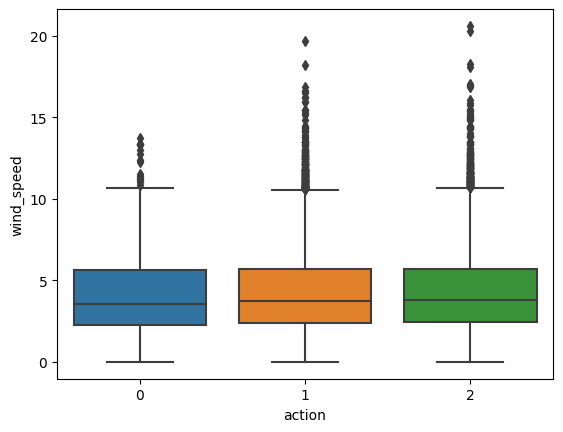

In [91]:
sns.boxplot(x='action', y='wind_speed', data=rewards_df)
# plt.savefig("./plots/ws_per_action_6.png");

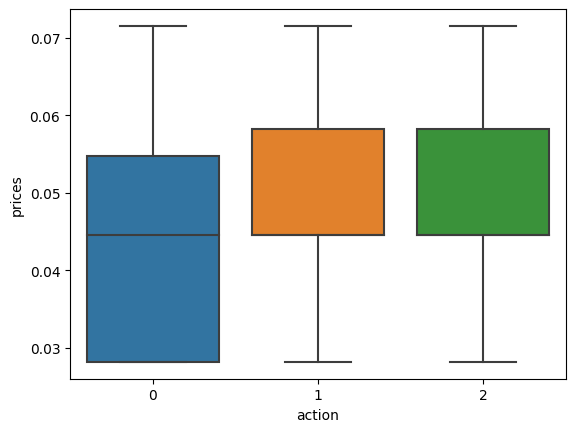

In [92]:
sns.boxplot(x='action', y='prices', data=rewards_df)
# plt.savefig("./plots/prices_per_action_6.png");

<Figure size 1400x800 with 0 Axes>

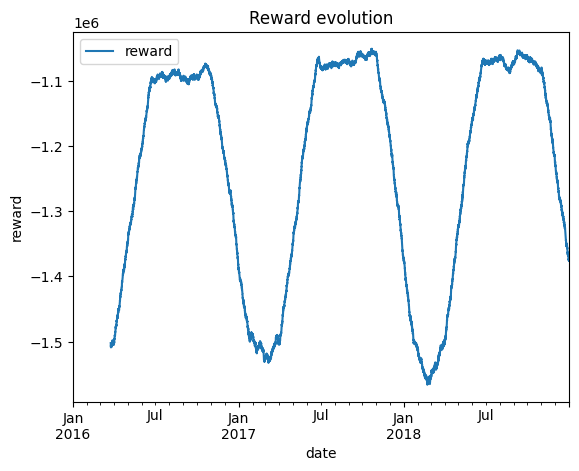

In [151]:
plt.figure(figsize=(14, 8))
pd.DataFrame({"reward":reward_list}, index=wind_hydrogen.index[:-1]).rolling(window=2000).mean().plot()
plt.xlabel('date')
plt.ylabel('reward')
plt.title('Reward evolution');
# plt.savefig("./plots/average_reward.png");

In [89]:
# model.save("acc_windhy_3")

# Repredicting with the first A2C model

WARNING: there are changes certainly due to the random seed or initialization which might bring different results.

In [66]:
# del model
# model_2 = A2C.load("acc_windhy_2.zip")
# model_2_1 = A2C.load("acc_windhy_2_1.zip")

In [67]:
model_2_1.get_parameters()

{'policy': OrderedDict([('mlp_extractor.policy_net.0.weight',
               tensor([[ 2.3501e-01, -4.8584e-01, -1.1078e-01, -1.8404e-01, -6.0246e-02,
                         8.4400e-04, -1.7268e-01],
                       [-5.8634e-02, -8.6156e-02,  3.3883e-01,  1.2844e-01, -1.7183e-02,
                        -4.8143e-02, -1.2200e-01],
                       [ 2.4539e-01,  2.6419e-01, -5.6722e-02,  8.1050e-02, -1.5707e-01,
                         7.3248e-02,  3.0742e-01],
                       [ 6.5758e-02, -2.9582e-01, -2.5429e-01,  5.2124e-02,  5.5909e-02,
                        -1.4116e-01, -1.5335e-01],
                       [-6.7203e-02,  2.5865e-02, -2.5925e-01, -2.7949e-01, -2.9891e-01,
                         1.4584e-01,  1.4126e-01],
                       [-5.9343e-01, -6.1212e-02,  5.5303e-03, -3.2888e-01,  1.5849e-02,
                         1.9919e-01, -1.2902e-01],
                       [ 2.3904e-01,  2.9939e-01,  1.7491e-01,  1.3747e-01, -2.2361e-02,
         

In [52]:
# reward_list = []
# action_list = []
# obs = env.reset()
# done = False
# while not done:
#     action, _states = model.predict(obs)
#     obs, rewards, done, info = env.step(action)
#     action_list.append(action)
#     reward_list.append(rewards)
#     env.render()

In [53]:
# rewards_df = pd.DataFrame({"reward":reward_list, 
#                            "wind_speed":wind_hydrogen["wind_speed"][1:],
#                            "prices":wind_hydrogen["prices"][1:],
#                            "action":action_list}, index=wind_hydrogen.index[1:])

In [54]:
# rewards_df.query("action==2").describe()

In [55]:
# sns.boxplot(x='action', y='wind_speed', data=rewards_df)

In [56]:
# sns.boxplot(x='action', y='prices', data=rewards_df)